# Nodal cycle

Investigate the source of nodal cycle along the Dutch coast. Compare the observed nodal cycle, the equilibrium tide and the nodal cycle influence on steric sea level.

In [57]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
import xarray as xr

import SeaLevelContrib as slc

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Import data from GAM model study

In [58]:
gam = pd.read_csv("/Users/sbult/Desktop/Scripts/data/tide gauges/output/Brest/results_NearestPointAverage2.csv")
#gam = pd.read_csv("/Users/sbult/Desktop/Scripts/data/tide gauges/output/Hosojima/results_NodalTide.csv")
gam.set_index("time", inplace=True)

obs_nod = gam["nod1"]+gam["nod2"]
obs_nod.name = "Observed cycle"

## Compute the equilibrium tide

In [59]:
latitude_netherlands = 53
latitude_brest = 48
latitude_newlyn = 50
latitude_stavanger = 59
latitude_denmark = 54
latitude_cascais = 39
latitude_ceuta = 36
latitude_esbjerg = 55
latitude_bergen = 60
latitude_northshields = 55
latitude_kungsholmsfort = 56
latitude_swinoujscie = 54
latitude_ketchikan = 55
latitude_tofino = 49
latitude_yakutat = 59
latitude_seattle = 47
latitude_kushiro = 43
latitude_pensacola = 30
latitude_keywest = 24
latitude_grandisle = 29
latitude_mera = 35
latitude_hosojima = 32

et = slc.nodal_tides_potential(latitude_brest, gam.index)
et = et.rename(columns={"Nodal":"Equilibrium tide"})

In [60]:
print(et)

      Equilibrium tide
time                  
1890         -0.021550
1891          0.139132
1892          0.284105
1893          0.397000
1894          0.465068
...                ...
2017         -0.439613
2018         -0.349409
2019         -0.219754
2020         -0.065285
2021          0.096555

[132 rows x 1 columns]


## Compute the nodal cycle in steric sea level

Try to remove the low frequency variability while keeping the nodal cycle

In [36]:
# Choose maximum depth of integration, region and start year for the analysis
max_depth = 400
region = "EBB"
start_year = 1960
end_year = 2020

In [37]:
StericSL_EBB_df = slc.StericSL('EN4_22', 'EBB', 0, max_depth, 0)
StericSL_BB_df = slc.StericSL('IAP', 'BB', 0, max_depth, 0)
StericSL_NWS_df = slc.StericSL('IAP', 'NWS', 0, max_depth, 0)
StericSL_ENS_df = slc.StericSL('IAP', 'ENS', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]
StericSL_BB_df.columns = ["Steric_BB"]
StericSL_NWS_df.columns = ["Steric_NWS"]
StericSL_ENS_df.columns = ["Steric_ENS"]

StericSL_df = StericSL_EBB_df.join([StericSL_BB_df,StericSL_NWS_df,StericSL_ENS_df])

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:end_year]

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [38]:
def thickness_from_depth(depth):
    '''Define a thickness Data Array from depth coordinate'''
    midp = (np.array(depth[1:])+np.array(depth[:-1]))/2
    midp = np.insert(midp, 0, np.array([0]))
    midp = np.insert(midp, len(midp), np.array(depth[-1]) + 
                     (np.array(depth[-1]) - np.array(depth[-2])))
    thick = midp[1:] - midp[:-1]
    thick_da = xr.DataArray(thick, coords={'depth': depth[:]}, dims='depth')
    return thick_da

def StericSL2(data_source, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'EN4_22':
        density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da
    
    rho_0 = density_ds.density[0 ,0 ,: ,:];
    
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL

<AxesSubplot:xlabel='time'>

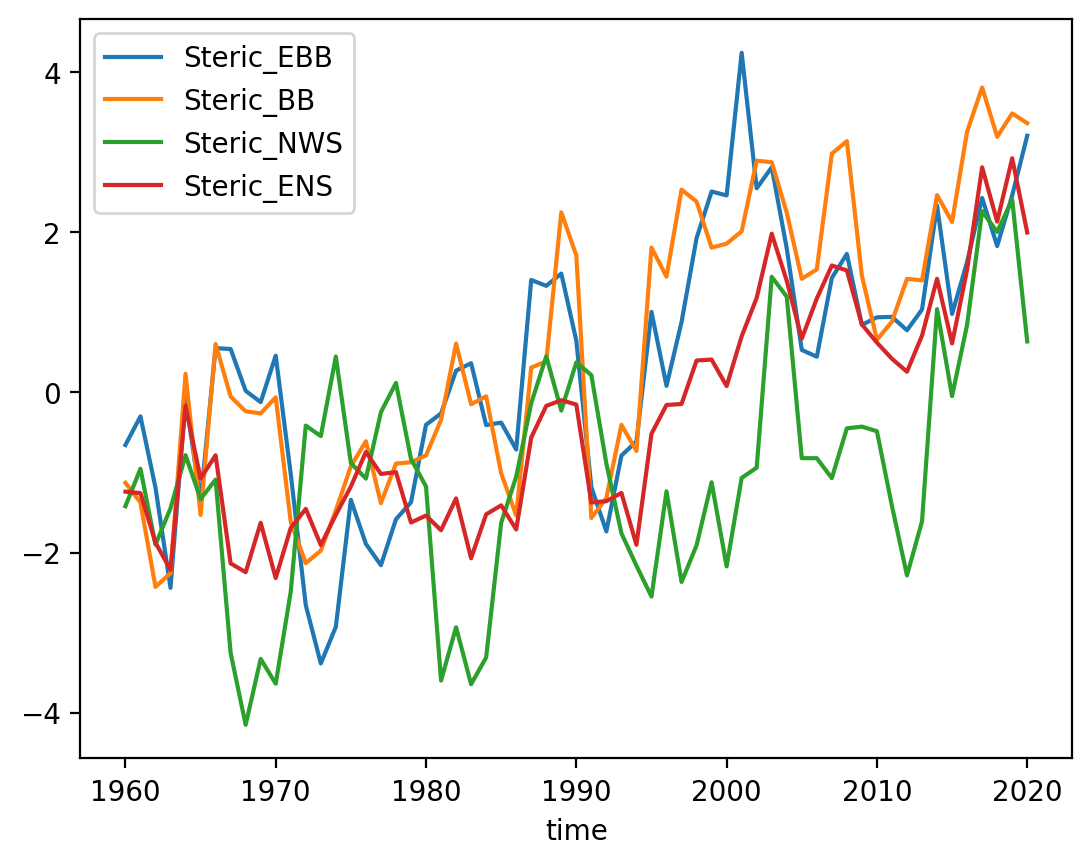

In [39]:
StericSL_df.iloc[:,0:4].plot()

In [8]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

In [9]:
#tg_id = 133

#lats, lons = slc.tg_lat_lon(tg_id)

# ster = StericSL2('EN4_22',0,500,0)
# ster = ster.loc[1960:]
# ster = ster.sel(lat=lats-2,lon=lons+2,method='nearest')

# t = np.arange(1960,2022,1)
# reg_df = pd.DataFrame({'Steric':ster},index=t)

# reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
# reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

In [10]:
reg_df

Steric      nod1      nod2
time                              
1960 -0.657302  1.000000  0.000000
1961 -0.299662  0.943562  0.331195
1962 -1.188667  0.780620  0.625006
1963 -2.441746  0.529565  0.848270
1964 -0.072344  0.218735  0.975784
...        ...       ...       ...
2016  1.628586  0.998523  0.054322
2017  2.428247  0.924178  0.381962
2018  1.827529  0.745516  0.666488
2019  2.460627  0.482703  0.875784
2020  3.205532  0.165405  0.986226

[61 rows x 3 columns]

In [11]:
gam_df = len(t)//2
gam_alpha = 5000

In [12]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

In [13]:
res_nr, res_full_nr = compute_model(reg_df)

In [14]:
print(res_full_nr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Steric   No. Observations:                   61
Model:                         GLMGam   Df Residuals:                    55.88
Model Family:                Gaussian   Df Model:                         4.12
Link Function:               identity   Scale:                         0.83618
Method:                         PIRLS   Log-Likelihood:                -78.427
Date:                Fri, 25 Aug 2023   Deviance:                       46.729
Time:                        12:28:23   Pearson chi2:                     46.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8863
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5291      0.340     -4.502      0.0

In [15]:
res_nr

nod1      nod2     trend     total  nodal_steric
time                                                      
1960 -0.185695  0.000000 -1.529128 -1.714823     -0.185695
1961 -0.175215  0.338901 -1.487697 -1.324010      0.163687
1962 -0.144957  0.639549 -1.446124 -0.951532      0.494592
1963 -0.098337  0.868008 -1.404228 -0.634558      0.769670
1964 -0.040618  0.998490 -1.361895 -0.404023      0.957872
...        ...       ...       ...       ...           ...
2016 -0.185421  0.055586  2.013327  1.883493     -0.129835
2017 -0.171615  0.390850  2.065722  2.284957      0.219235
2018 -0.138438  0.681996  2.117942  2.661500      0.543558
2019 -0.089636  0.896162  2.170095  2.976622      0.806527
2020 -0.030715  1.009174  2.222232  3.200691      0.978459

[61 rows x 5 columns]

### Check the GAM model results

<AxesSubplot:xlabel='time'>

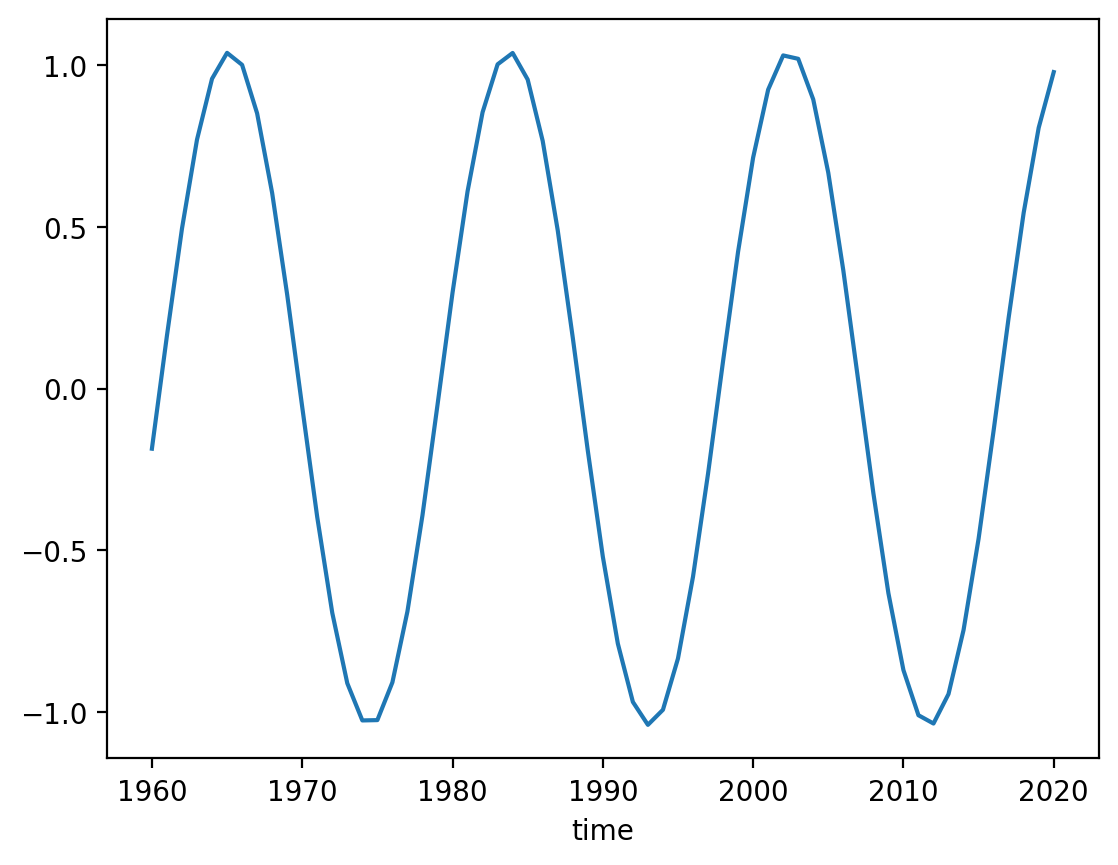

In [16]:
res_nr["nodal_steric"].plot()

In [17]:
max(res_nr["nodal_steric"])

1.0379530263207923

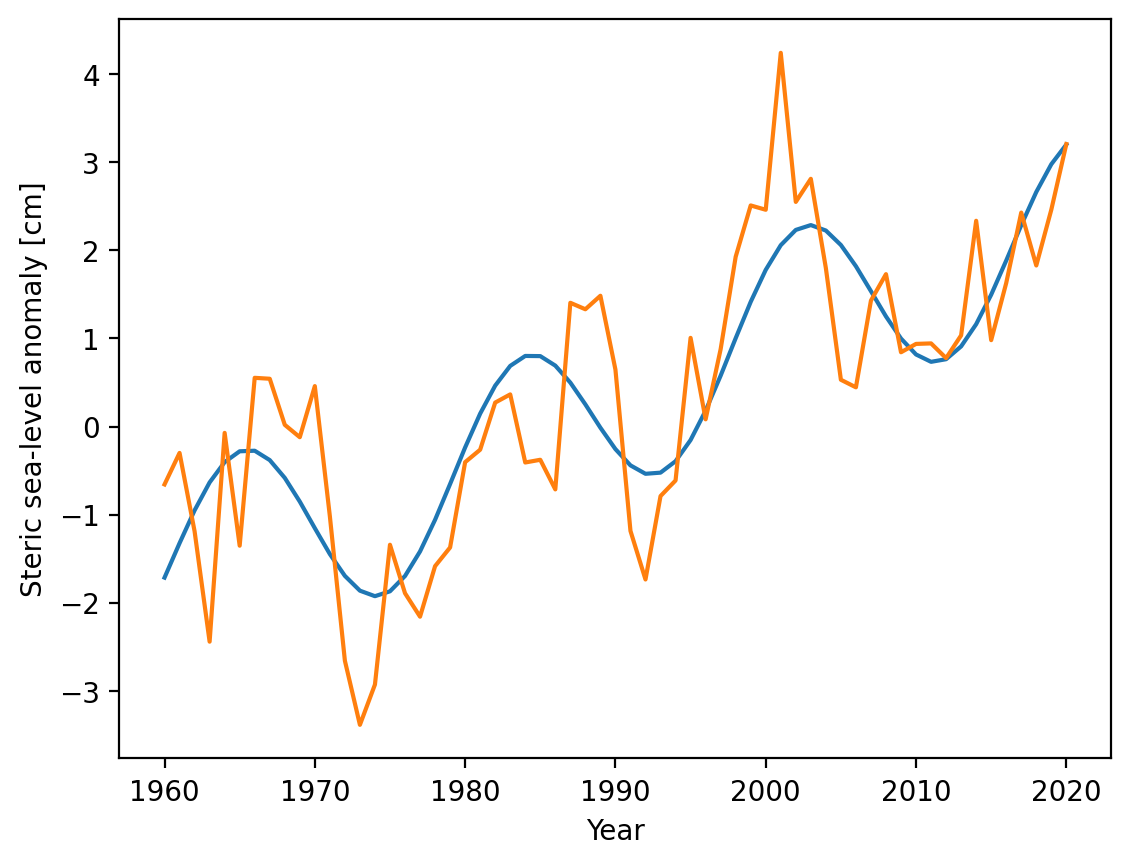

In [18]:
from sklearn.metrics import mean_squared_error
import math

#MSE = mean_squared_error(StericSL_df[f"Steric_{region}"], res_nr["total"])
#RMSE = math.sqrt(MSE)

from scipy.stats import chisquare

#stats = chisquare(StericSL_df[f"Steric_{region}"],res_nr['total']);

#print(stats)

plt.plot(res_nr["total"])
plt.plot(StericSL_df[f"Steric_{region}"])

plt.ylabel('Steric sea-level anomaly [cm]')
plt.xlabel('Year');

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/stericfit.png', dpi=150)

<AxesSubplot:xlabel='time'>

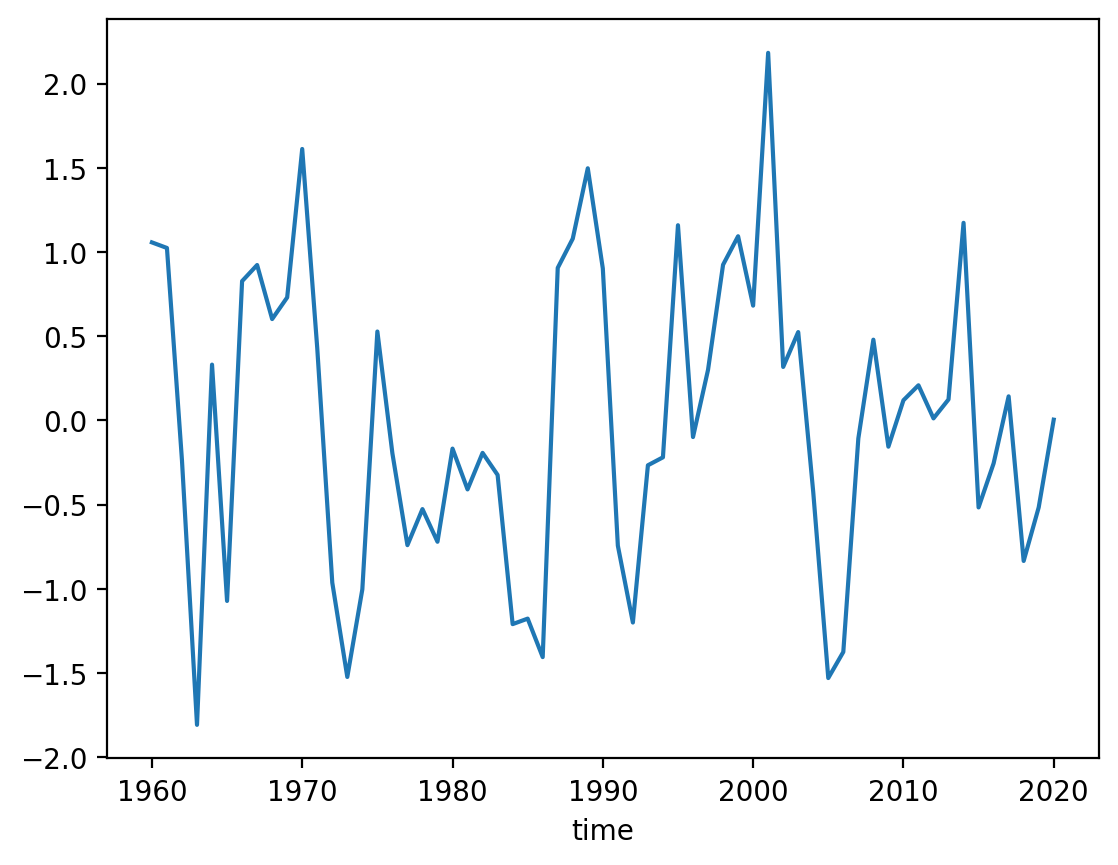

In [19]:
(StericSL_df[f"Steric_{region}"]-res_nr["total"]).plot()

In [20]:
abs(StericSL_df["Steric_EBB"]-res_nr["total"]).sum()

43.81350027240813

## Join the different nodal terms together

In [44]:
nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
#nodal_df["Eq+Steric"] = eq + nodal_df["nodal_steric"]

In [41]:
nodal_df

Equilibrium tide  Observed cycle  nodal_steric  Eq+Steric
time                                                           
1890         -0.029972        0.577931           NaN        NaN
1891          0.193503        0.729409           NaN        NaN
1892          0.395129        0.798554           NaN        NaN
1893          0.552141        0.777562           NaN        NaN
1894          0.646809        0.668802           NaN        NaN
...                ...             ...           ...        ...
2017         -0.611406       -0.241610      0.219235  -0.392171
2018         -0.485952        0.025255      0.543558   0.057605
2019         -0.305629        0.289268      0.806527   0.500898
2020         -0.090797        0.520630      0.978459   0.887662
2021          0.134287        0.693226           NaN        NaN

[132 rows x 4 columns]

1960
2002


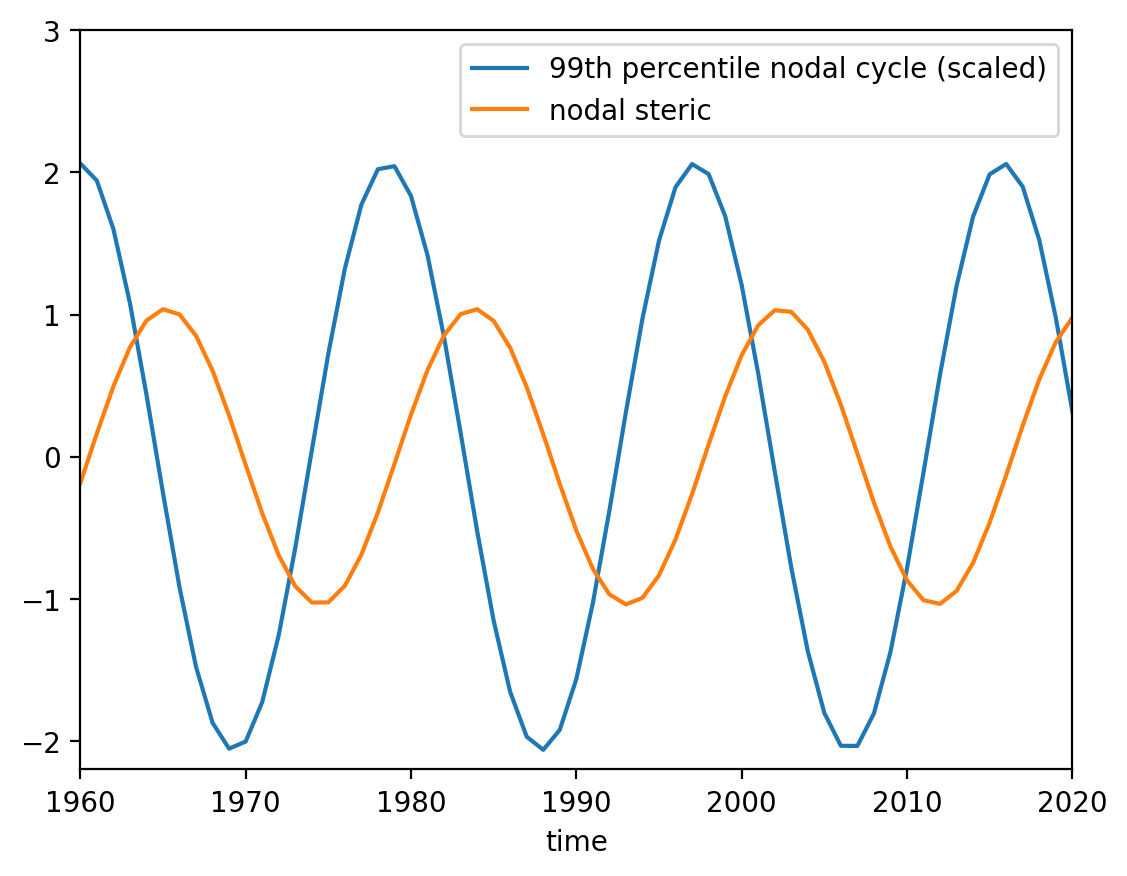

In [23]:
cycles = pd.ExcelFile('/Users/sbult/Desktop/Scripts/data/tide gauges/Tidal_cycles.xlsx')
br = pd.read_excel(cycles, 'Brest', index_col=[0])
be = pd.read_excel(cycles, 'Bergen', index_col=[0])
diff = np.diff(nodal_df['nodal_steric'])*6
(br['18.6 YEAR']*20).plot(label='99th percentile nodal cycle (scaled)');
#plt.plot(np.linspace(1891,2021,131),diff,label='Derivative')
nodal_df['nodal_steric'].plot(label='nodal steric')
plt.xlim([1960,2020])
plt.ylim([-2.2,3])
plt.legend();

br_1922 = br['18.6 YEAR'].loc[1955:1975]
print(br_1922.idxmax())
print(nodal_df['nodal_steric'].loc[1993:2011].idxmax())

#pd.DataFrame.to_csv(nodal_df['nodal_steric'],'/Users/sbult/Desktop/Scripts/data/tide gauges/nodal_steric.csv')

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/NodalCycle_comparison_99th&steric_19932011.pdf', dpi=150)

Text(0, 0.5, 'Sea level [cm]')

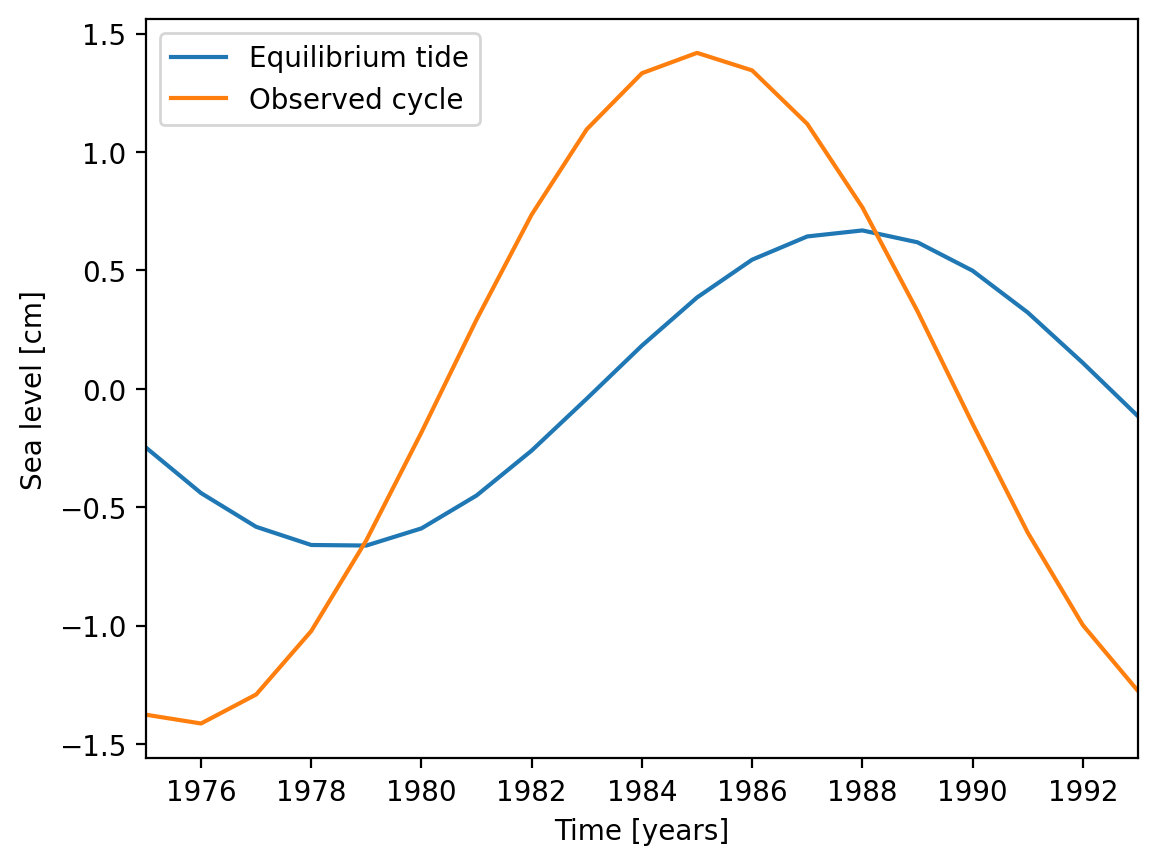

In [24]:
fig, ax = plt.subplots()

nodal_df[['Equilibrium tide','Observed cycle']].plot(ax=ax)
ax.set_xlim([1975,1993])
# ax.set_xlim([1993,2011])
# ax.set_xlim([1997,2021])
ax.set_xlabel("Time [years]")
ax.set_ylabel("Sea level [cm]")

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/difference_nodalcycle.pdf', dpi=150)

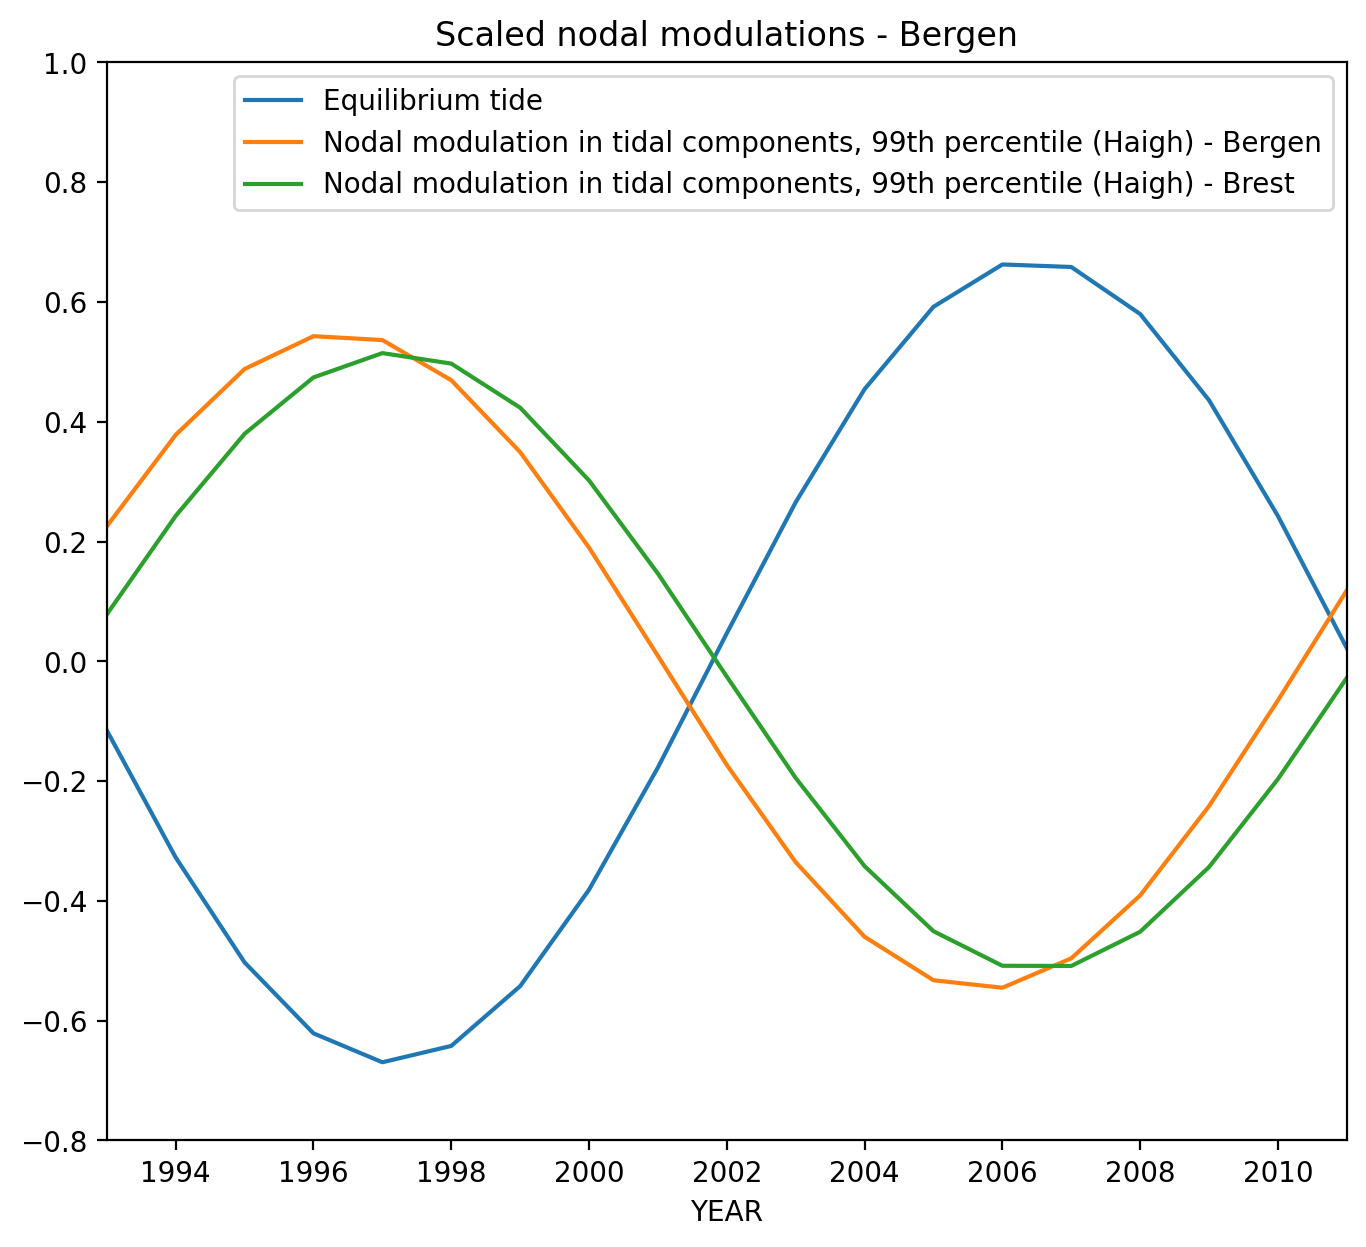

In [25]:
fig, ax = plt.subplots(figsize=(8,7))

nodal_df[['Equilibrium tide']].plot(ax=ax,label='Equilibrium tide')
#(nodal_df[['Observed cycle']]/2).plot(ax=ax)
(be['18.6 YEAR']*40).plot(ax=ax,label='Nodal modulation in tidal components, 99th percentile (Haigh) - Bergen')
(br['18.6 YEAR']*5).plot(ax=ax,label='Nodal modulation in tidal components, 99th percentile (Haigh) - Brest')
#plt.plot(m2[:,0],(m2[:,1]-np.mean(m2[:,1]))/15,label='Nodal modulation in M2 component (Pineau-Guillou et al., 2021)');
plt.legend()
plt.title('Scaled nodal modulations - Bergen')

ax.set_xlim([1993,2011]);
ax.set_ylim([-0.8,1]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/nodalmodulations_BergenVSBrest.png', dpi=150)

4.33414634146341


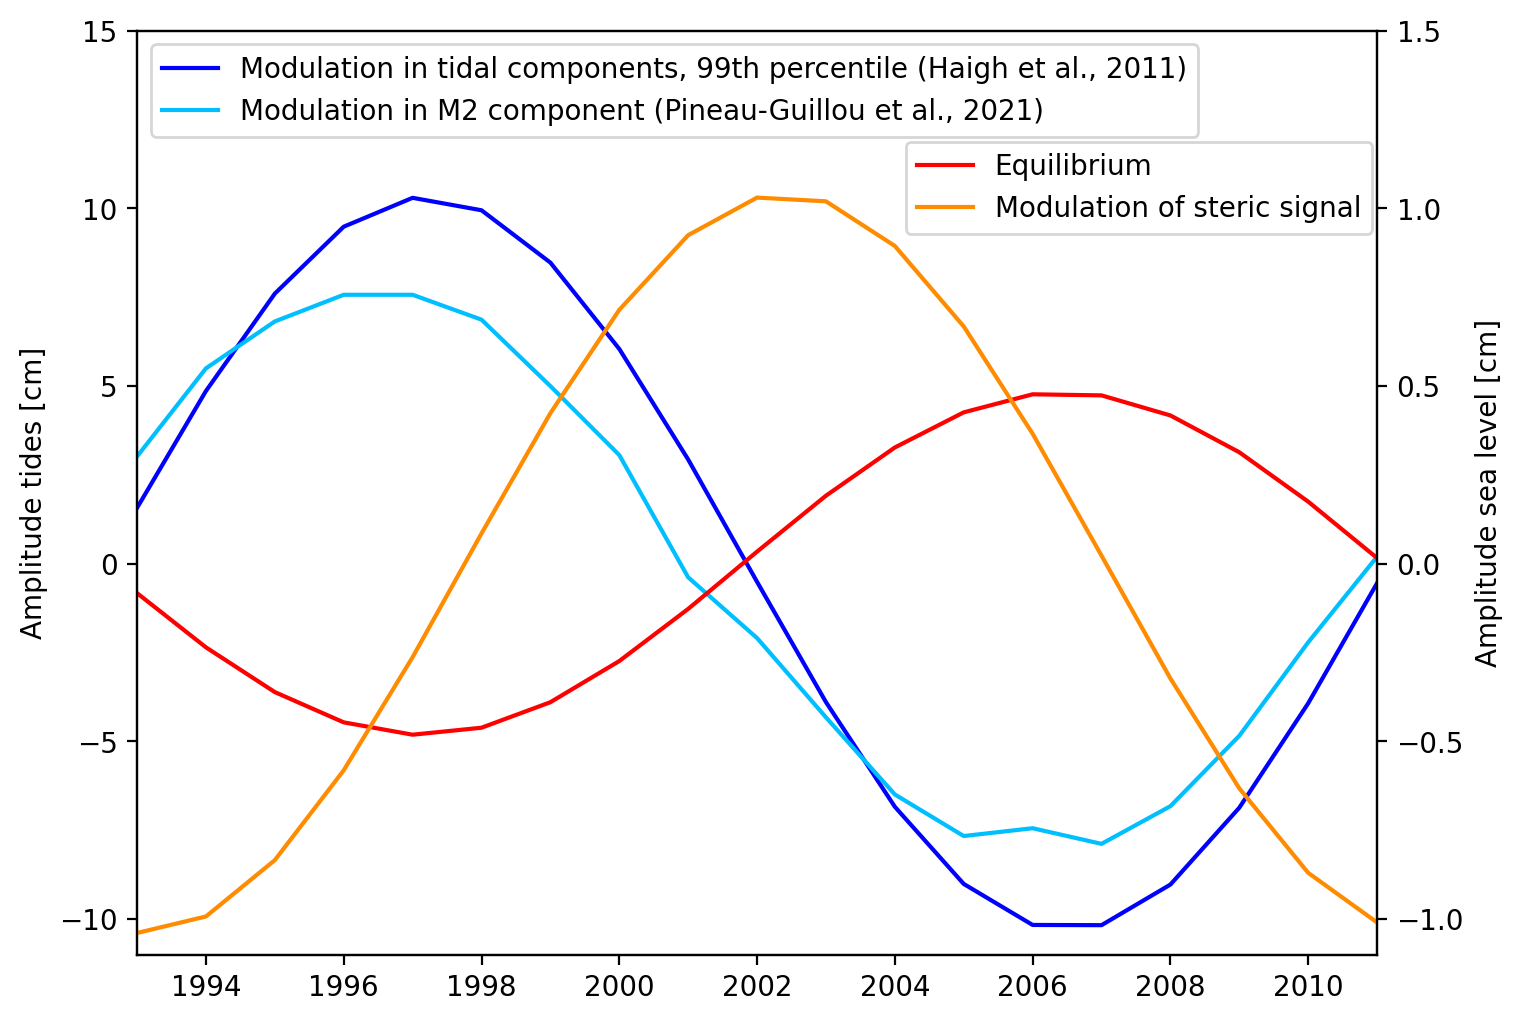

In [47]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(br['18.6 YEAR']*100,'b',label='Modulation in tidal components, 99th percentile (Haigh et al., 2011)');
ax.plot(m2[:,0],m2[:,1]-np.mean(m2[:,1]),'deepskyblue',label='Modulation in M2 component (Pineau-Guillou et al., 2021)')
ax.set_xlim([1993,2011])
ax.set_ylabel('Amplitude tides [cm]')
ax.legend(loc='upper left')
ax.set_ylim([-11,15]);

ax2=ax.twinx()
ax2.plot(nodal_df[['Equilibrium tide']],'r',label='Equilibrium')
ax2.plot(nodal_df['nodal_steric'],'darkorange', label='Modulation of steric signal')
ax2.set_ylabel('Amplitude sea level [cm]')
ax2.legend(loc=(0.62,0.78))
ax2.set_ylim([-1.1,1.5]);

print(np.max((m2[:,1]-np.mean(m2[:,1]))/205)*100)
#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/nodalmodulations_Brest.png', dpi=150)

NameError: name 'm2' is not defined

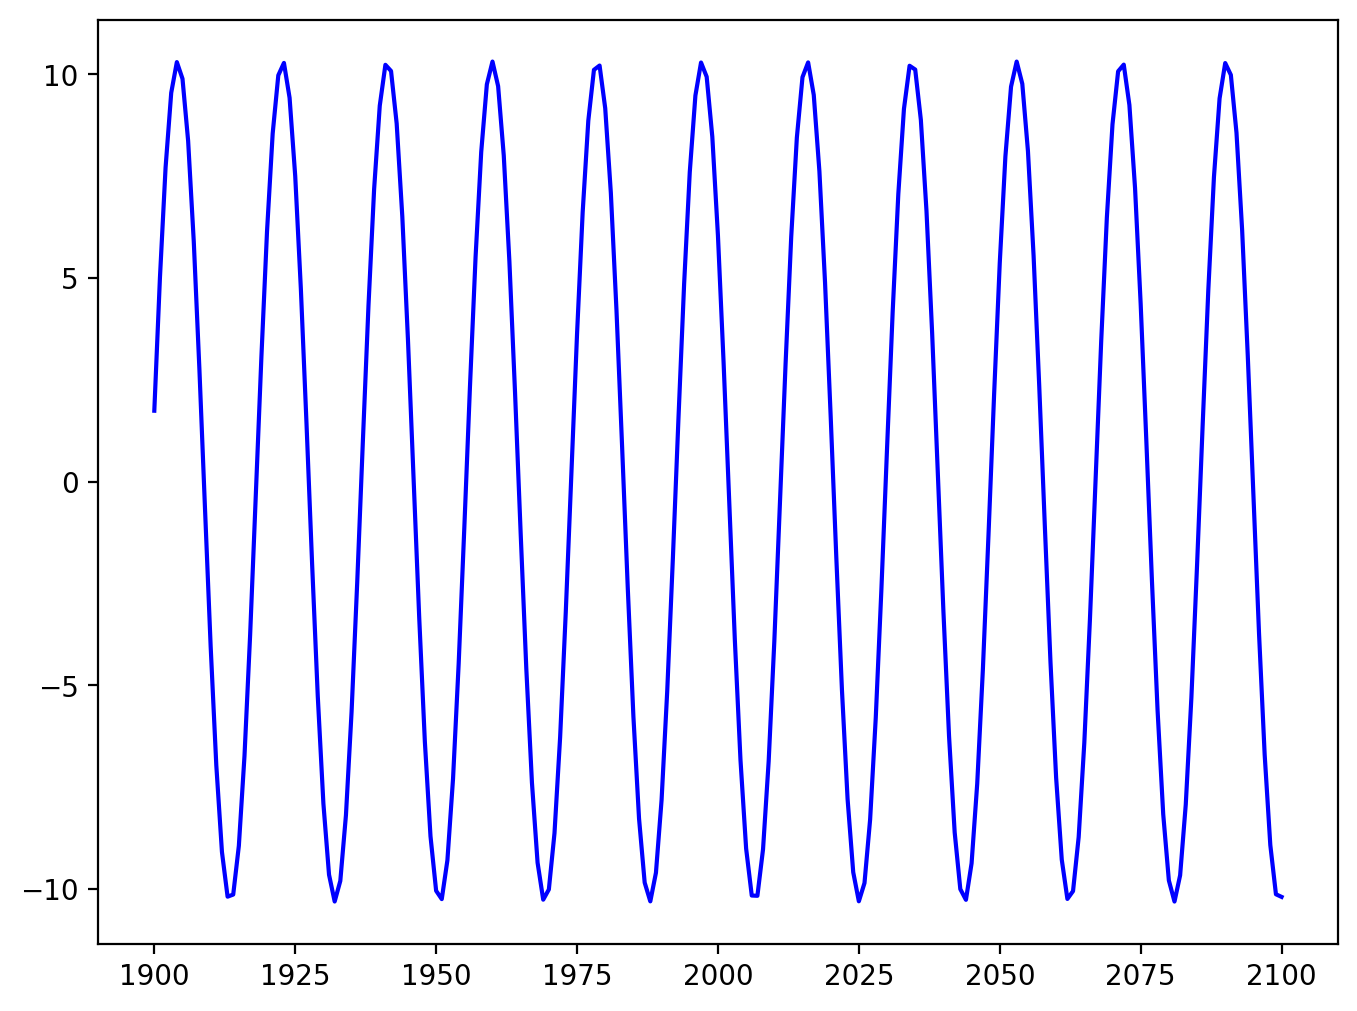

In [27]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(br['18.6 YEAR']*100,'b',label='Nodal modulation in high-frequency tidal components (Haigh et al., 2011)');
ax.plot(m2[:,0],m2[:,1]-np.mean(m2[:,1]),'deepskyblue',label='Nodal modulation in M2 component (Pineau-Guillou et al., 2021)')
ax.set_xlim([1993,2011])
ax.set_ylabel('Amplitude tides [cm]')
ax.legend(loc='upper left')
ax.set_ylim([-11,15]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/nodalmodulations_highfreqtides.png', dpi=150)

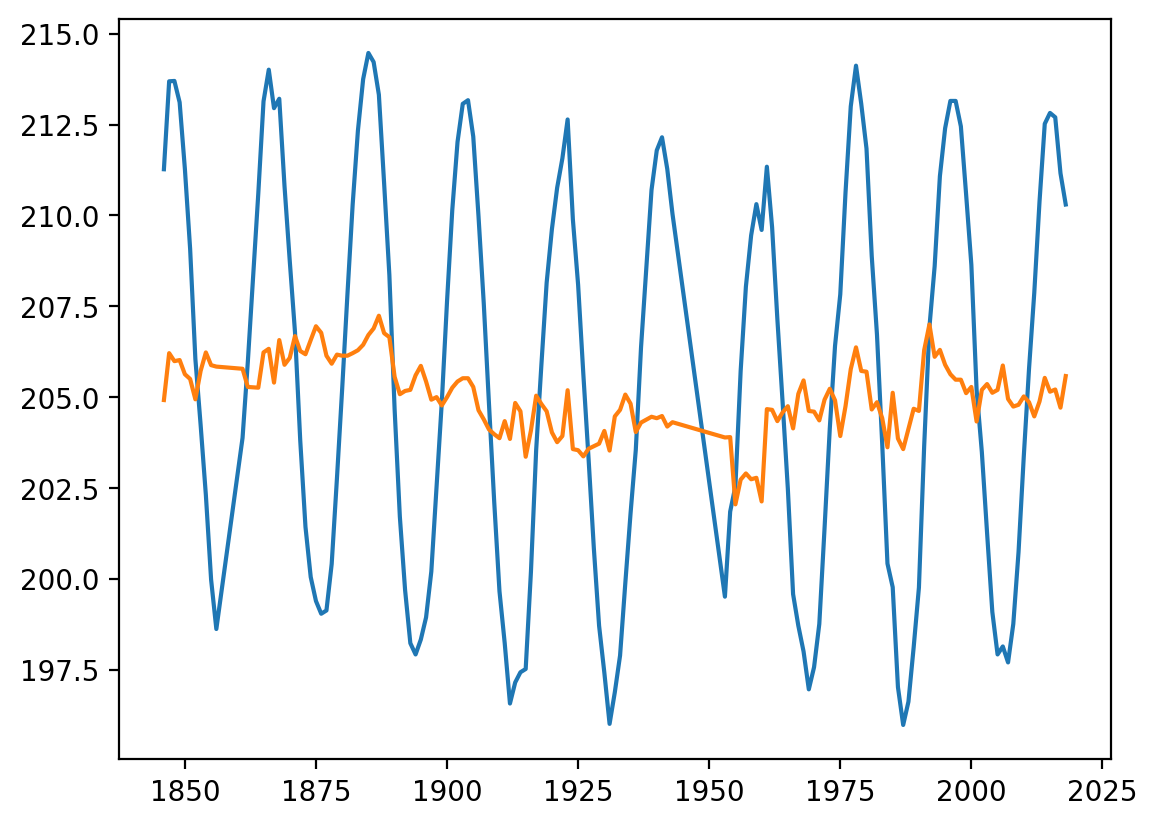

In [28]:
m2 = np.loadtxt('/Users/sbult/Downloads/M2-files/M2-BREST_without_nod_cor.txt')
m2_nc = np.loadtxt('/Users/sbult/Downloads/M2-files/M2-BREST.txt')
plt.plot(m2[:,0],m2[:,1]);
plt.plot(m2_nc[:,0],m2_nc[:,1]);

## Prepare a nice summary figure

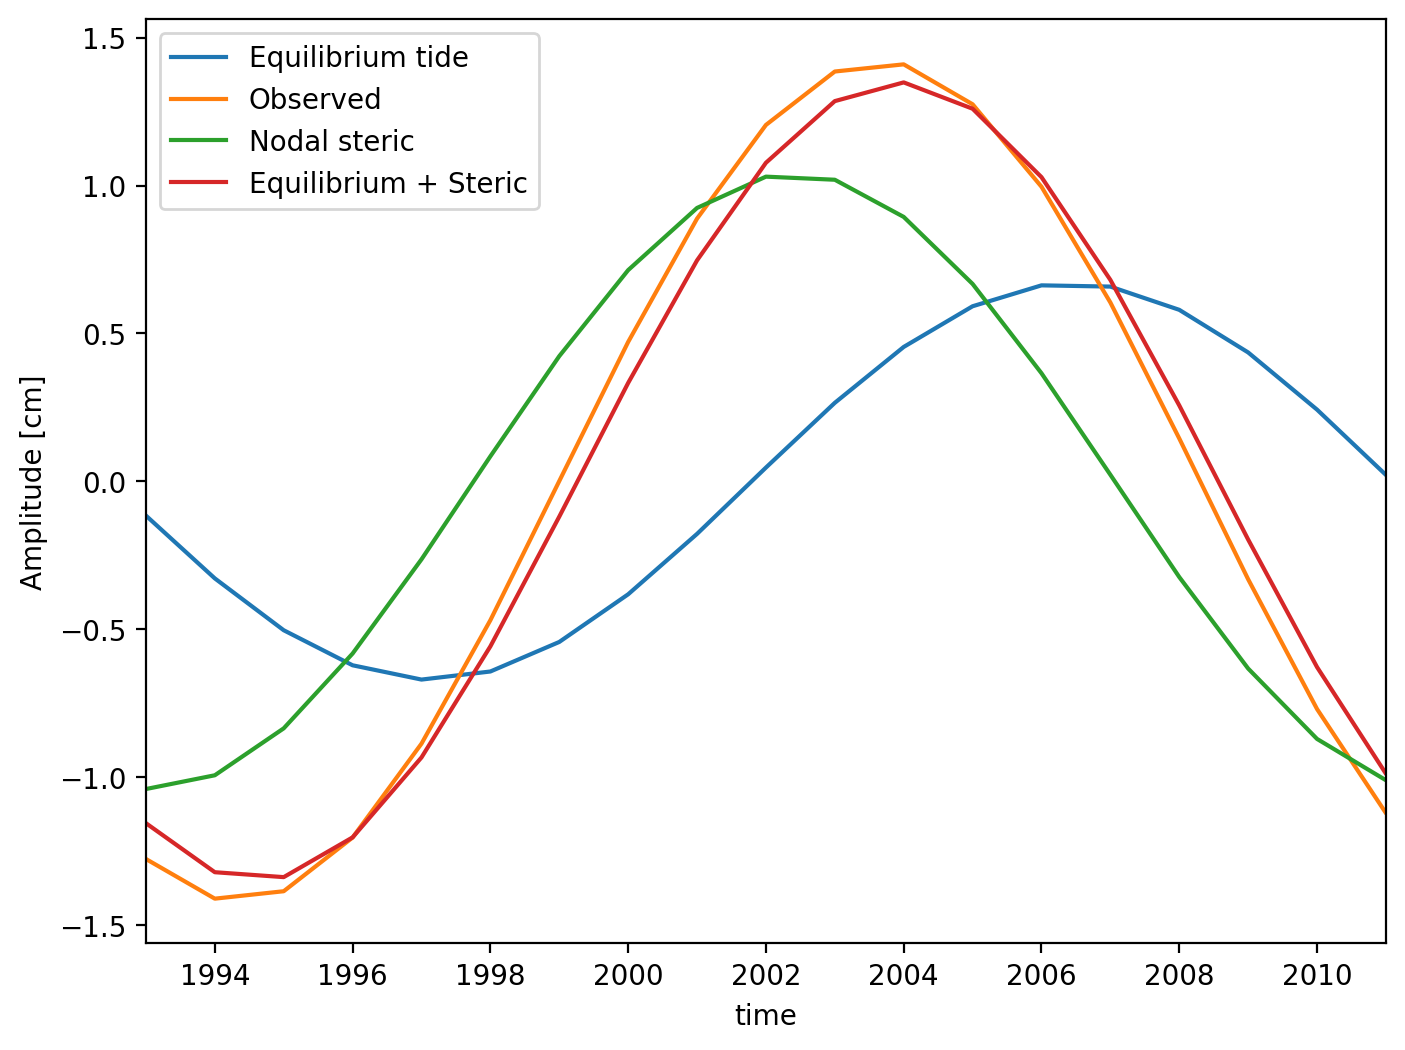

In [103]:
#fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig = plt.figure(figsize=(8,6));

#ax[0].plot(res_nr["total"], label="Trend and nodal fit")
#ax[0].plot(StericSL_df[f"Steric_{region}"], label=f"Observed steric in {region}" )

#ax[0].legend()

#nodal_df.plot(ax=ax[1])
nodal_df['Equilibrium tide'].plot(label='Equilibrium tide')
nodal_df['Observed cycle'].plot(label='Observed')
nodal_df['nodal_steric'].plot(label='Nodal steric')
nodal_df['Eq+Steric'].plot(label='Equilibrium + Steric')
#br['18.6 YEAR'].plot(ax=ax[1]);

plt.xlim([1993,2011]);
plt.legend(loc='upper left')
plt.ylabel('Amplitude [cm]');
#ax[1].set_xlim([1993,2011])

#for i in range(2):
 #   ax[i].set_xlabel("Time [years]")
  #  ax[i].set_ylabel("Sea level [cm]")

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/NodalCycle_eq&obs_only.png', dpi=150)

In [29]:
new = nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]

<AxesSubplot:xlabel='time'>

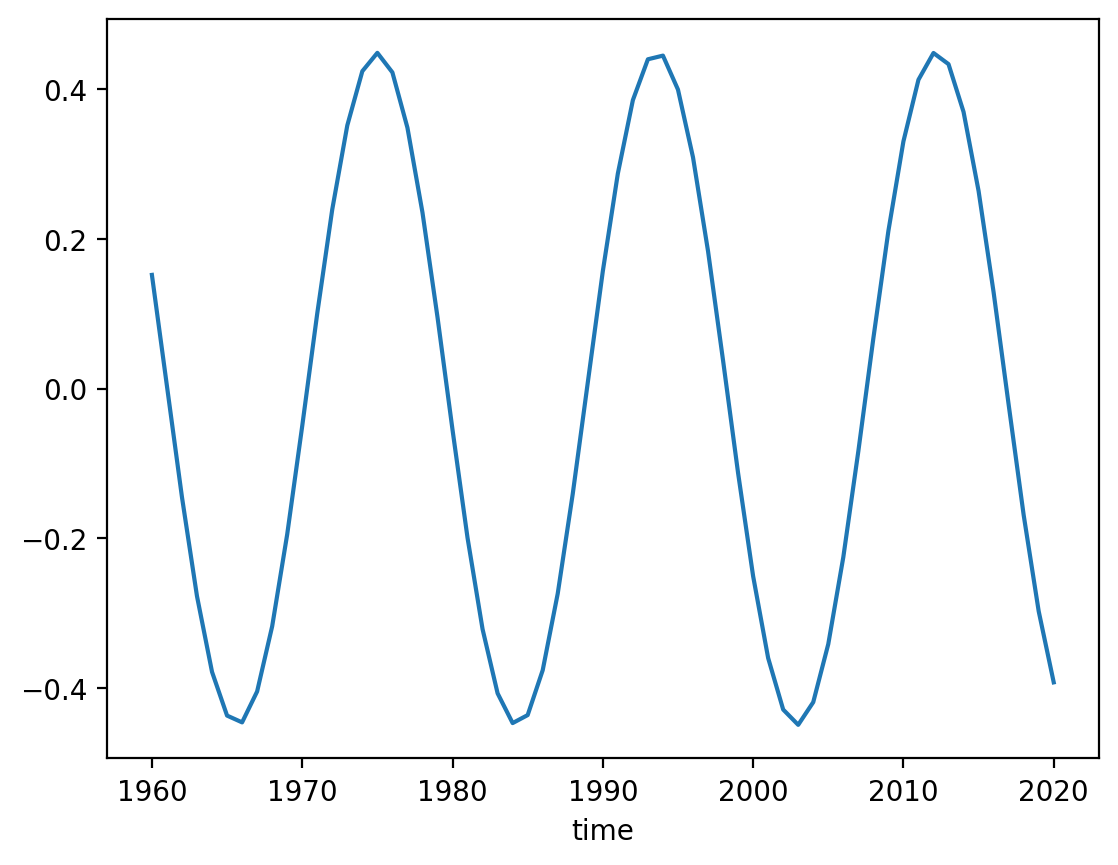

In [30]:
new.plot()

In [31]:
a_es = nodal_df["Eq+Steric"].max()
da_es = nodal_df["Observed cycle"].max() - nodal_df["Eq+Steric"].max()
a_e = nodal_df["Equilibrium tide"].max()
ph_es = nodal_df["Eq+Steric"].loc[1993:2011].idxmax()
ph_e = nodal_df["Equilibrium tide"].loc[1993:2011].idxmax()
print(f'Amplitude Eq+Steric: {a_es} cm\ndAmplitude {da_es} cm\nAmplitude Eq: {a_e} cm\nPhase Eq: {ph_e}\nPhase "lead" Eq+Steric: {ph_e - ph_es} years')

Amplitude Eq+Steric: 1.2330391846586652 cm
dAmplitude -0.43131202551718995 cm
Amplitude Eq: 0.48189389338517985 cm
Phase Eq: 2006
Phase "lead" Eq+Steric: 2 years


In [32]:
import warnings
warnings.filterwarnings("once")

## Conclusions

For the EBB region the steric signal is largest when integrated over 500 m (amplitude 0.58 cm)

For the NWS region it is largest when integrated over 4000 m (amplitude of 0.74 cm).

ENS region has a smaller magnitude.

Removing the beginning ot the 20th century from the analysis makes the nodal cycle fit larger. This could be because the quality of the observations is not good enough.

The EBB is more in phase with the equilibrium tide so the sum of equilibrium tide and steric nodal cycle is larger for the EBB.


In [48]:
regions = ['Cascais','Brest','Newlyn','Vlissingen','Hoek van Holland','IJmuiden','Den Helder','Harlingen','Delfzijl','Cuxhaven','Esbjerg','North Shields','Stavanger','Bergen']

names = ['id','lat','lon','Amplitude eq+st','Amplitude eq','Amplitude obs','dA (obs-(eq+st))','dA (obs-eq)','Phase eq+st','Phase eq','Phase obs','dP (obs-(eq+st))','dP (obs-eq)','Amplitude st','Phase st']
ov = np.zeros([len(regions),15])

density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')

for i in range(len(regions)):
    gam = pd.read_csv(f"/Users/sbult/Desktop/Scripts/data/tide gauges/output/{regions[i]}/results_NearestPointAverage2.csv")
    gam.set_index("time", inplace=True)
    obs_nod = gam["nod1"]+gam["nod2"]
    obs_nod.name = "Observed cycle"
    
    if regions[i] == 'IJmuiden':
        latitude = latitude_netherlands
        tg_id = 32
    elif regions[i] == 'Vlissingen':
        latitude = latitude_netherlands
        tg_id = 20
    elif regions[i] == 'Den Helder':
        latitude = latitude_netherlands
        tg_id = 23
    elif regions[i] == 'Hoek van Holland':
        latitude = latitude_netherlands
        tg_id = 22
    elif regions[i] == 'Harlingen':
        latitude = latitude_netherlands
        tg_id = 25
    elif regions[i] == 'Delfzijl':
        latitude = latitude_netherlands
        tg_id = 24
    elif regions[i] == 'Brest':
        latitude = latitude_brest
        tg_id = 1
    elif regions[i] == 'Newlyn':
        latitude = latitude_newlyn
        tg_id = 202
    elif regions[i] == 'Stavanger':
        latitude = latitude_stavanger
        tg_id = 47
    elif regions[i] == 'Cuxhaven':
        latitude = latitude_denmark
        tg_id = 7
    elif regions[i] == 'Cascais':
        latitude = latitude_cascais
        tg_id = 52
    elif regions[i] == 'Esbjerg':
        latitude = latitude_esbjerg
        tg_id = 80
    elif regions[i] == 'Bergen':
        latitude = latitude_bergen
        tg_id = 58
    elif regions[i] == 'North Shields':
        latitude = latitude_northshields
        tg_id = 95
        
    lats, lons = slc.tg_lat_lon(tg_id)
    
    ster = StericSL2('EN4_22',0,400,0)
    ster = ster.loc[1960:]
    ster = ster.sel(lat=lats,lon=lons-2,method='nearest')
        
    et = slc.nodal_tides_potential(latitude, gam.index)
    et = et.rename(columns={"Nodal":"Equilibrium tide"})
    
    reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    
    res_nr, res_full_nr = compute_model(reg_df)
    
    nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])
    nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
    
    ov[i,0] = tg_id
    ov[i,1] = lats
    ov[i,2] = lons
    if regions[i] == 'Cascais':
        ov[i,6] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].max()
        ov[i,7] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1975:1993].max()
        ov[i,3] = nodal_df["Eq+Steric"].loc[1975:1993].max()
        ov[i,4] = nodal_df["Equilibrium tide"].loc[1975:1993].max()
        ov[i,5] = nodal_df["Observed cycle"].loc[1975:1993].max()
        ov[i,13] = nodal_df["nodal_steric"].loc[1975:1993].max()
        ov[i,8] = nodal_df["Eq+Steric"].loc[1975:1993].idxmax() + 18
        ov[i,9] = nodal_df["Equilibrium tide"].loc[1975:1993].idxmax() + 18
        ov[i,10] = nodal_df["Observed cycle"].loc[1975:1993].idxmax() + 18
    else:
        ov[i,6] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].max()
        ov[i,7] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1993:2011].max()
        ov[i,3] = nodal_df["Eq+Steric"].loc[1993:2011].max()
        ov[i,4] = nodal_df["Equilibrium tide"].loc[1993:2011].max()
        ov[i,5] = nodal_df["Observed cycle"].loc[1993:2011].max()
        ov[i,13] = nodal_df["nodal_steric"].loc[1993:2011].max()
        ov[i,8] = nodal_df["Eq+Steric"].loc[1993:2011].idxmax()
        ov[i,9] = nodal_df["Equilibrium tide"].loc[1993:2011].idxmax()
        ov[i,10] = nodal_df["Observed cycle"].loc[1993:2011].idxmax()
    if regions[i] == 'Cascais':
        ov[i,11] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].idxmax() + 18
        ov[i,12] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1975:1993].idxmax() + 18
        ov[i,14] = nodal_df["nodal_steric"].loc[1975:1993].idxmax() + 18
    else:
        ov[i,11] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].idxmax()
        ov[i,12] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1993:2011].idxmax()
        ov[i,14] = nodal_df["nodal_steric"].loc[1993:2011].idxmax()

ov2 = pd.DataFrame(ov,columns=names,index=regions)
#ov2.sort_values(by=['id'],ascending=True,inplace=True)
print(ov2)
#ov2.to_csv('/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv')

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


                     id        lat       lon  Amplitude eq+st  Amplitude eq  \
Cascais            52.0  38.683333 -9.416667         1.075182      0.137820   
Brest               1.0  48.382850 -4.494838         1.220749      0.476466   
Newlyn            202.0  50.103000 -5.542833         1.272339      0.551680   
Vlissingen         20.0  51.442222  3.596111         1.348464      0.662661   
Hoek van Holland   22.0  51.977500  4.120000         1.348464      0.662661   
IJmuiden           32.0  52.462222  4.554722         1.348464      0.662661   
Den Helder         23.0  52.964444  4.745000         1.348464      0.662661   
Harlingen          25.0  53.175556  5.409444         1.348464      0.662661   
Delfzijl           24.0  53.326389  6.933056         1.348464      0.662661   
Cuxhaven            7.0  53.866667  8.716667         1.373378      0.698983   
Esbjerg            80.0  55.460833  8.441111         1.398012      0.734896   
North Shields      95.0  55.007444 -1.439778        

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.


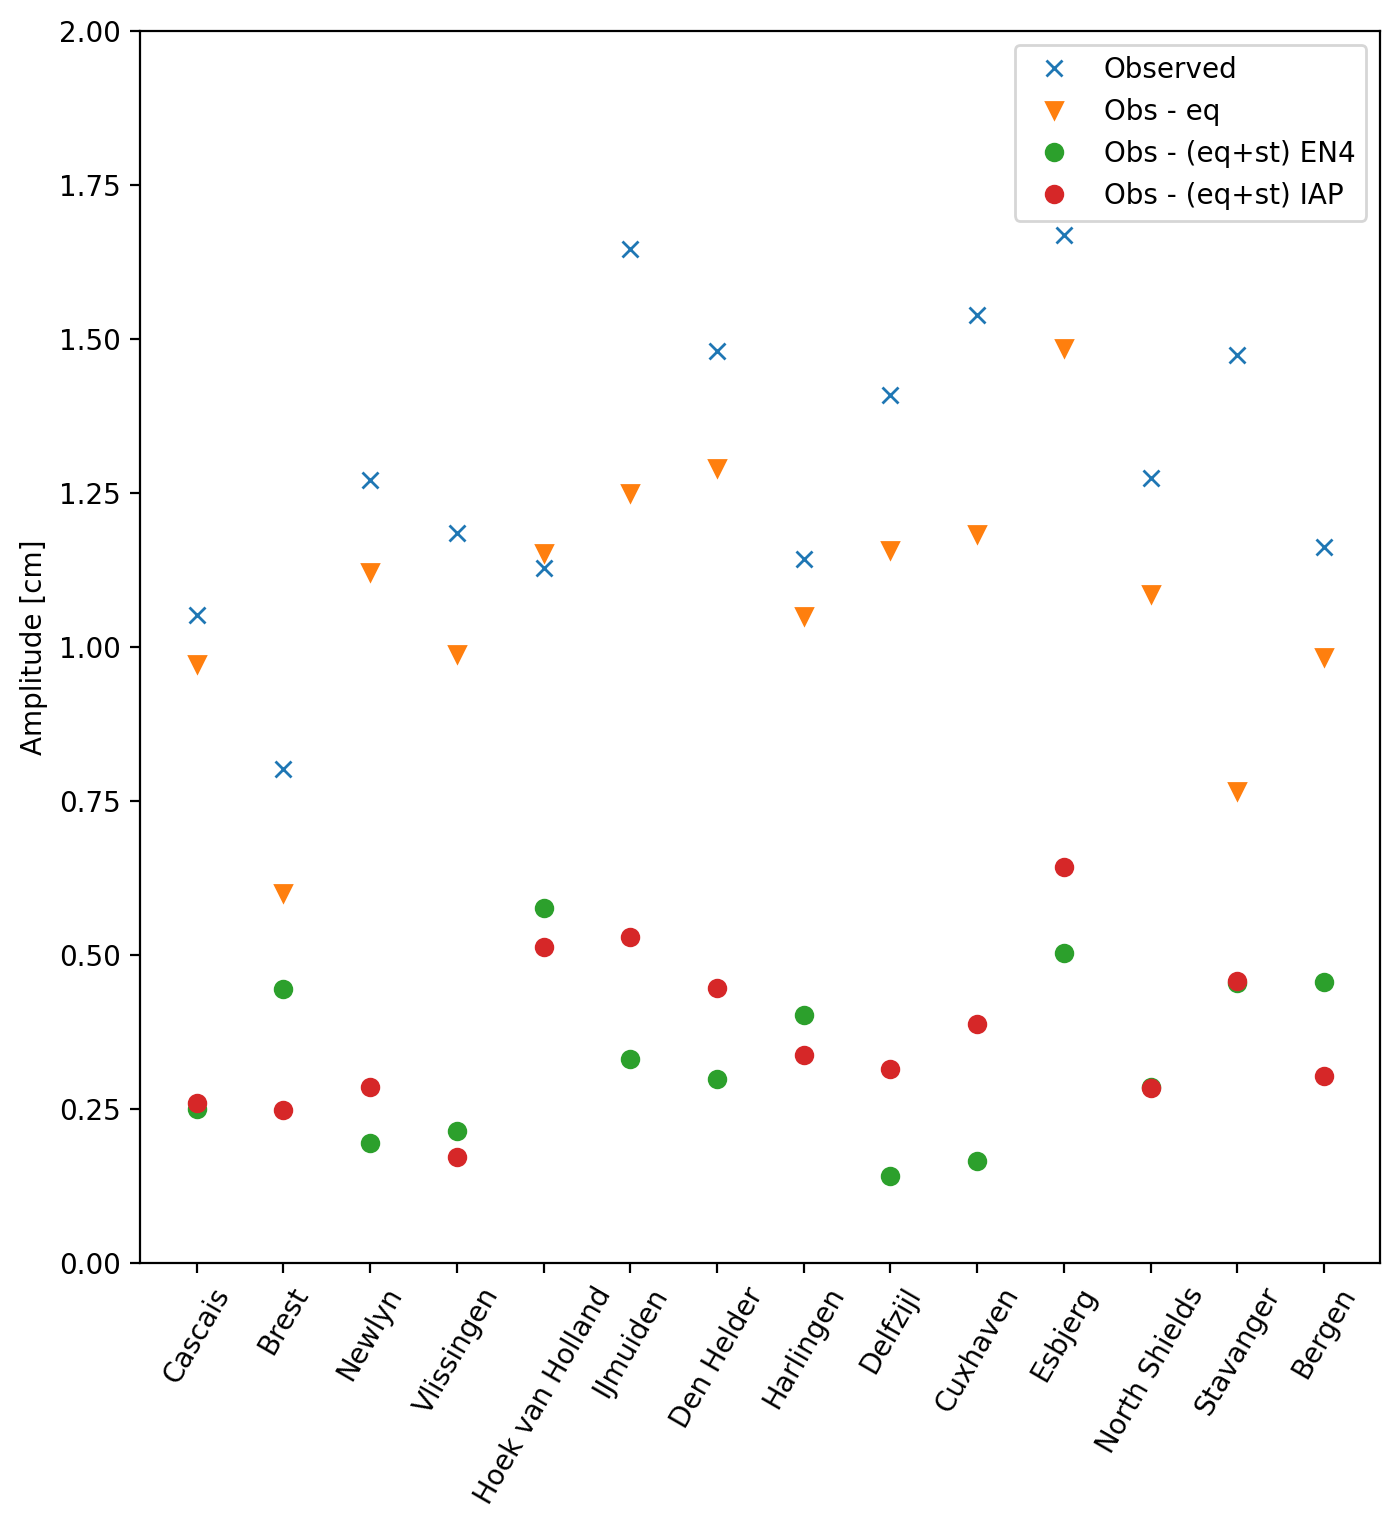

In [49]:
fig = plt.figure(figsize=(8,8))

#plt.axhline(0,color='k',ls='--')
#plt.axhline(0.25,color='k',ls='--',linewidth=1)
x = np.linspace(0,14,14)

ov2_v = pd.read_csv(f'/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv')
mean = ov2_v['dA (obs-(eq+st))'].mean()
plt.plot(x,ov2_v['Amplitude obs'],'x',label='Observed')
plt.plot(x,ov2_v['dA (obs-eq)'],'v',label='Obs - eq')

version = ['IAP EBB 500m 1940-2020','IAP EBB 2000m 1940-2020','IAP EBB 500m 1980-2020','IAP EBB 2000m 1980-2020','EN4 EBB 500m 1940-2020','EN4 EBB 2000m 1940-2020','EN4 EBB 500m 1980-2020','EN4 EBB 2000m 1980-2020','EN4 NWS 500m 1980-2020','EN4 NWS 2000m 1980-2020','IAP NWS 500m 1980-2020','IAP NWS 2000m 1980-2020','EN4 EBB 500m 1960-2020']

#prange = [1,2,3,5,6,12]
prange = [12,13]
method = ['EN4','IAP']

for i in [0,1]:
    ov2_v = pd.read_csv(f'/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v{i+13}.csv')
    plt.plot(x,ov2_v['dA (obs-(eq+st))'],'o',label='Obs - (eq+st) '+str(method[i]))
    plt.legend();
    plt.xticks(ticks=x,labels=regions,rotation = 60);
    plt.ylabel('Amplitude [cm]');
    plt.ylim([0, 2])

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/amplitude_difference.png', dpi=300,bbox_inches='tight')

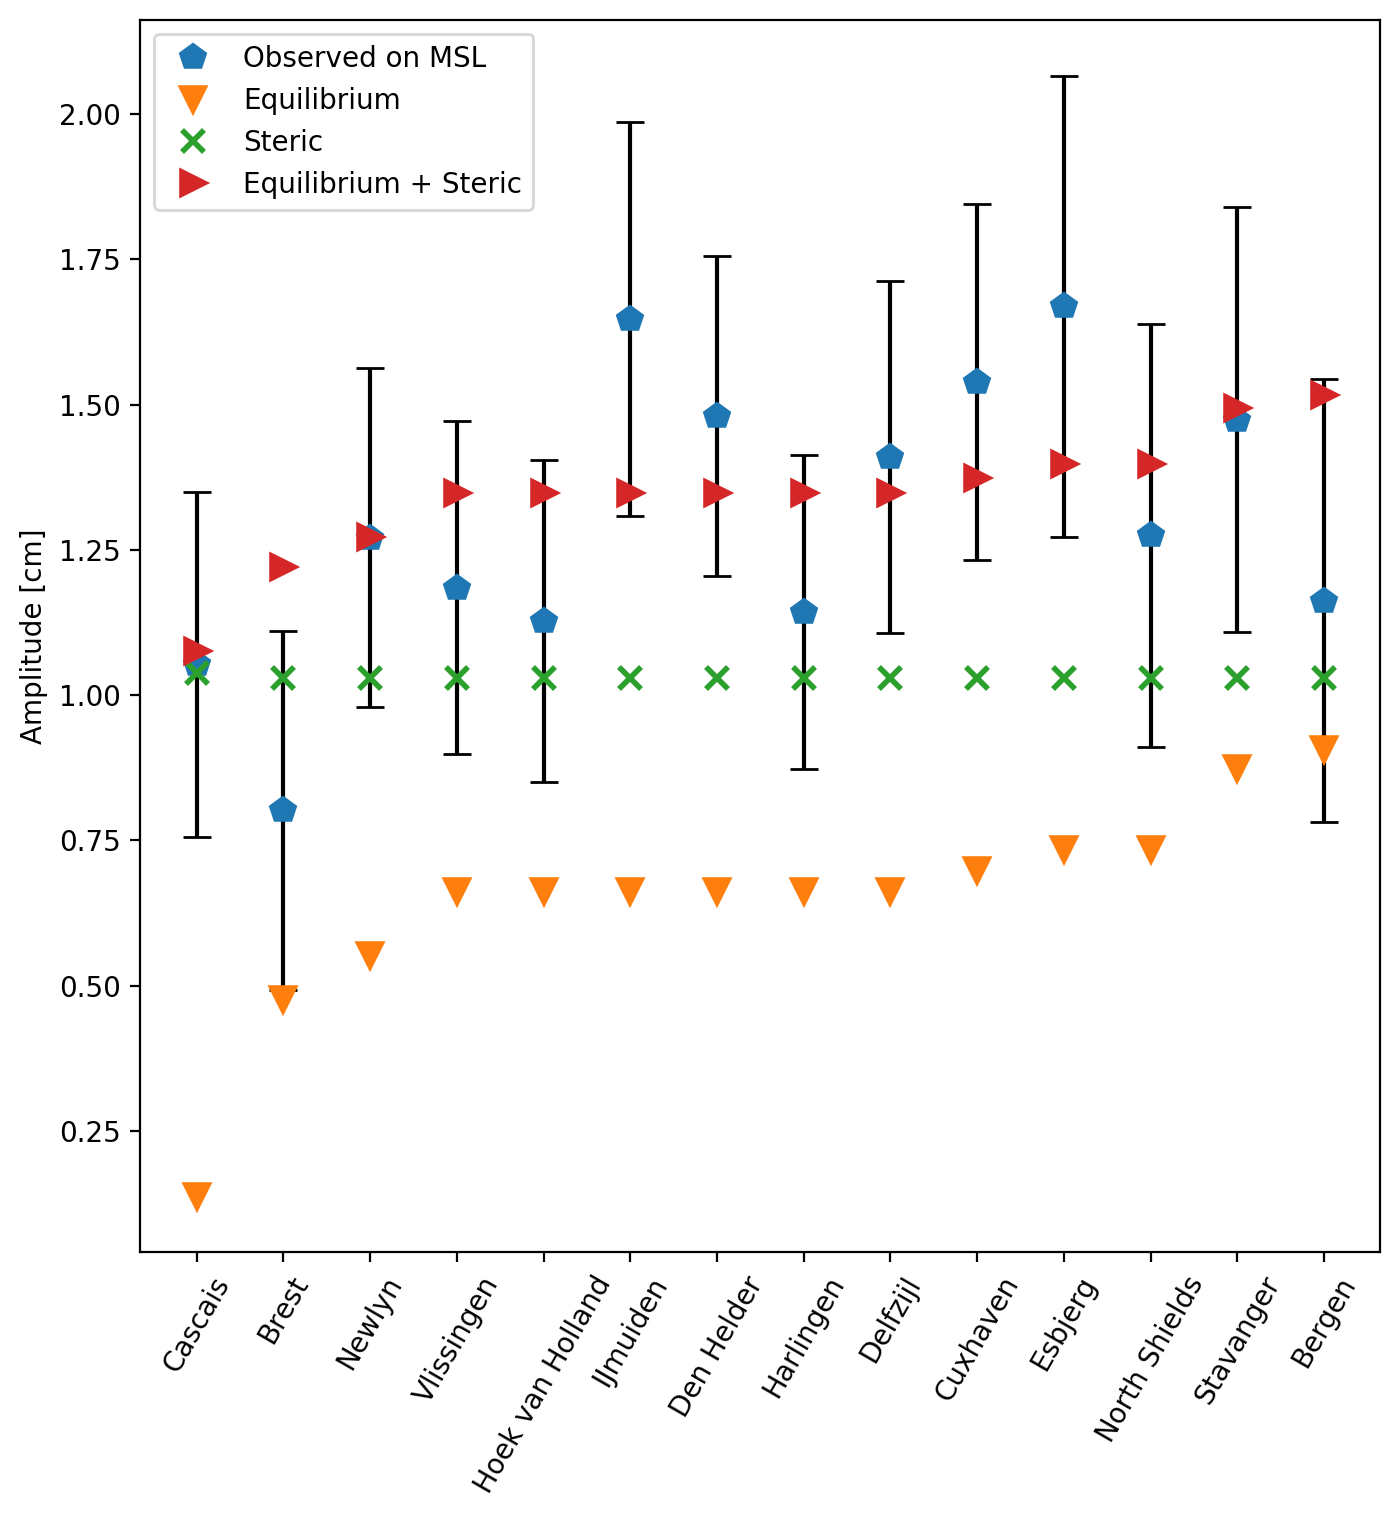

In [53]:
fig = plt.figure(figsize=(8,8))

#plt.axhline(0,color='k',ls='--')
#plt.axhline(0.25,color='k',ls='--',linewidth=1)
x = np.linspace(0,14,14)

ov2_v = pd.read_csv(f'/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv')
mean = ov2_v['dA (obs-(eq+st))'].mean()
obs = ov2_v['Amplitude obs']

plt.errorbar(x[0],obs[0],yerr=0.29653311136763993,capsize=5,color='black')
plt.errorbar(x[1],obs[1],yerr=0.3087421335767129,capsize=5,color='black')
plt.errorbar(x[2],obs[2],yerr=0.2915266079883838,capsize=5,color='black')
plt.errorbar(x[3],obs[3],yerr=0.2869182504231681,capsize=5,color='black')
plt.errorbar(x[4],obs[4],yerr=0.27767323299631524,capsize=5,color='black')
plt.errorbar(x[5],obs[5],yerr=0.3386961062839413,capsize=5,color='black')
plt.errorbar(x[6],obs[6],yerr=0.27578352897412006,capsize=5,color='black')
plt.errorbar(x[7],obs[7],yerr=0.26981091917498157,capsize=5,color='black')
plt.errorbar(x[8],obs[8],yerr=0.30259726176991714,capsize=5,color='black')
plt.errorbar(x[9],obs[9],yerr=0.3061636782173685,capsize=5,color='black')
plt.errorbar(x[10],obs[10],yerr=0.3963642914527672,capsize=5,color='black')
plt.errorbar(x[11],obs[11],yerr=0.364596116356427,capsize=5,color='black')
plt.errorbar(x[12],obs[12],yerr=0.3659219304068599,capsize=5,color='black')
plt.errorbar(x[13],obs[13],yerr=0.3806283265822585,capsize=5,color='black')

plt.plot(x,ov2_v['Amplitude obs'],'p',label='Observed on MSL',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude eq'],'v',label='Equilibrium',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude st'],'x',label='Steric',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude eq+st'],'>',label='Equilibrium + Steric',mew=2,ms=8)
plt.ylabel('Amplitude [cm]')
plt.xticks(ticks=x,labels=regions,rotation = 60)
plt.legend();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/amplitudes.png', dpi=150,bbox_inches='tight')

0.8671428571428572


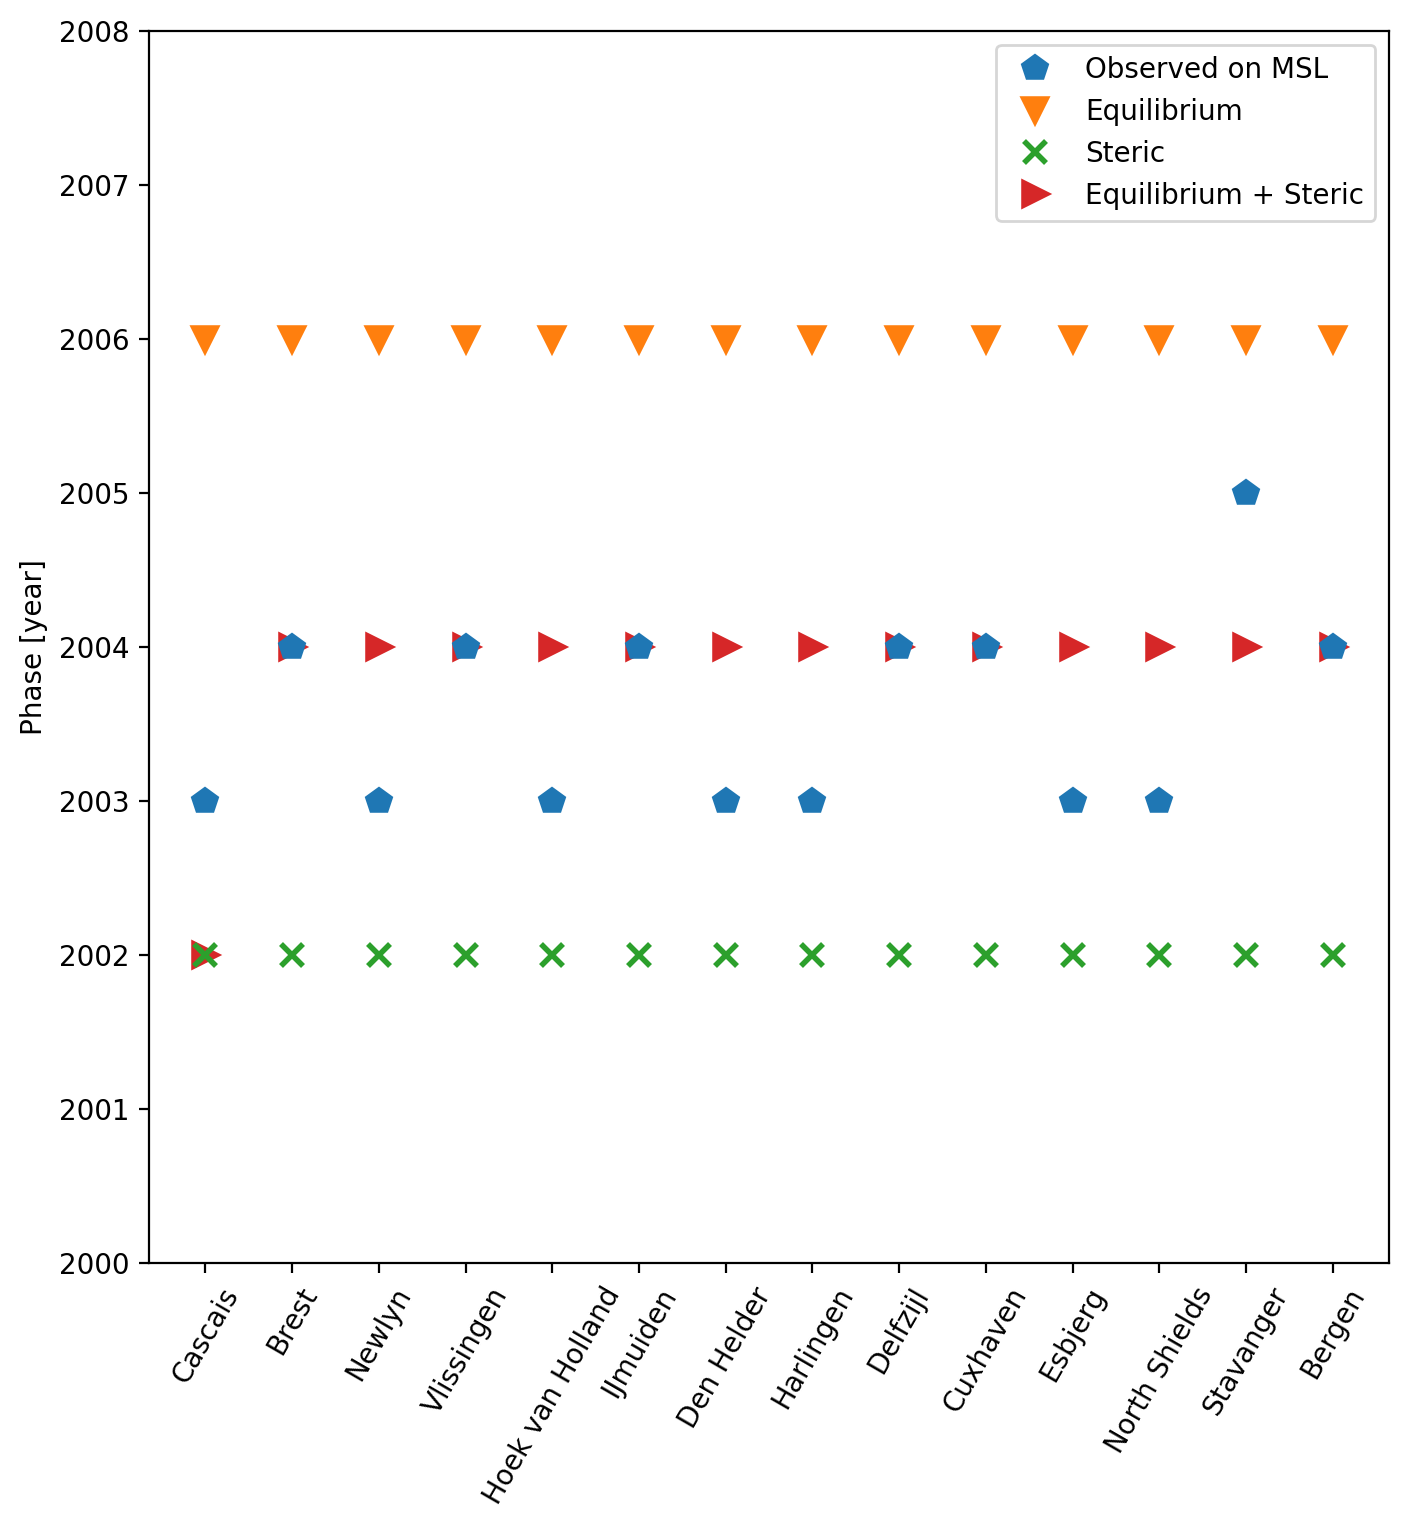

In [56]:
fig = plt.figure(figsize=(8,8))

x = np.linspace(0,14,14)

ov2_v = pd.read_csv(f'/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv')

error = [0.96,1.37,0.79,0.62,0.85,0.69,0.64,0.80,0.72,1.42,0.80,0.78,0.82,0.88]

print(np.mean(error))

plt.plot(x,ov2_v['Phase obs'],'p',label='Observed on MSL',mew=2,ms=8,zorder=1)
plt.plot(x,ov2_v['Phase eq'],'v',label='Equilibrium',mew=2,ms=8)
plt.plot(x,ov2_v['Phase st'],'x',label='Steric',mew=2,ms=8)
plt.plot(x,ov2_v['Phase eq+st'],'>',label='Equilibrium + Steric',mew=2,ms=8,zorder=0)
plt.ylabel('Phase [year]')
plt.xticks(ticks=x,labels=regions,rotation = 60)
plt.legend();
#plt.xlim([])
plt.ylim([2000,2008]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/phases.png', dpi=150,bbox_inches='tight')

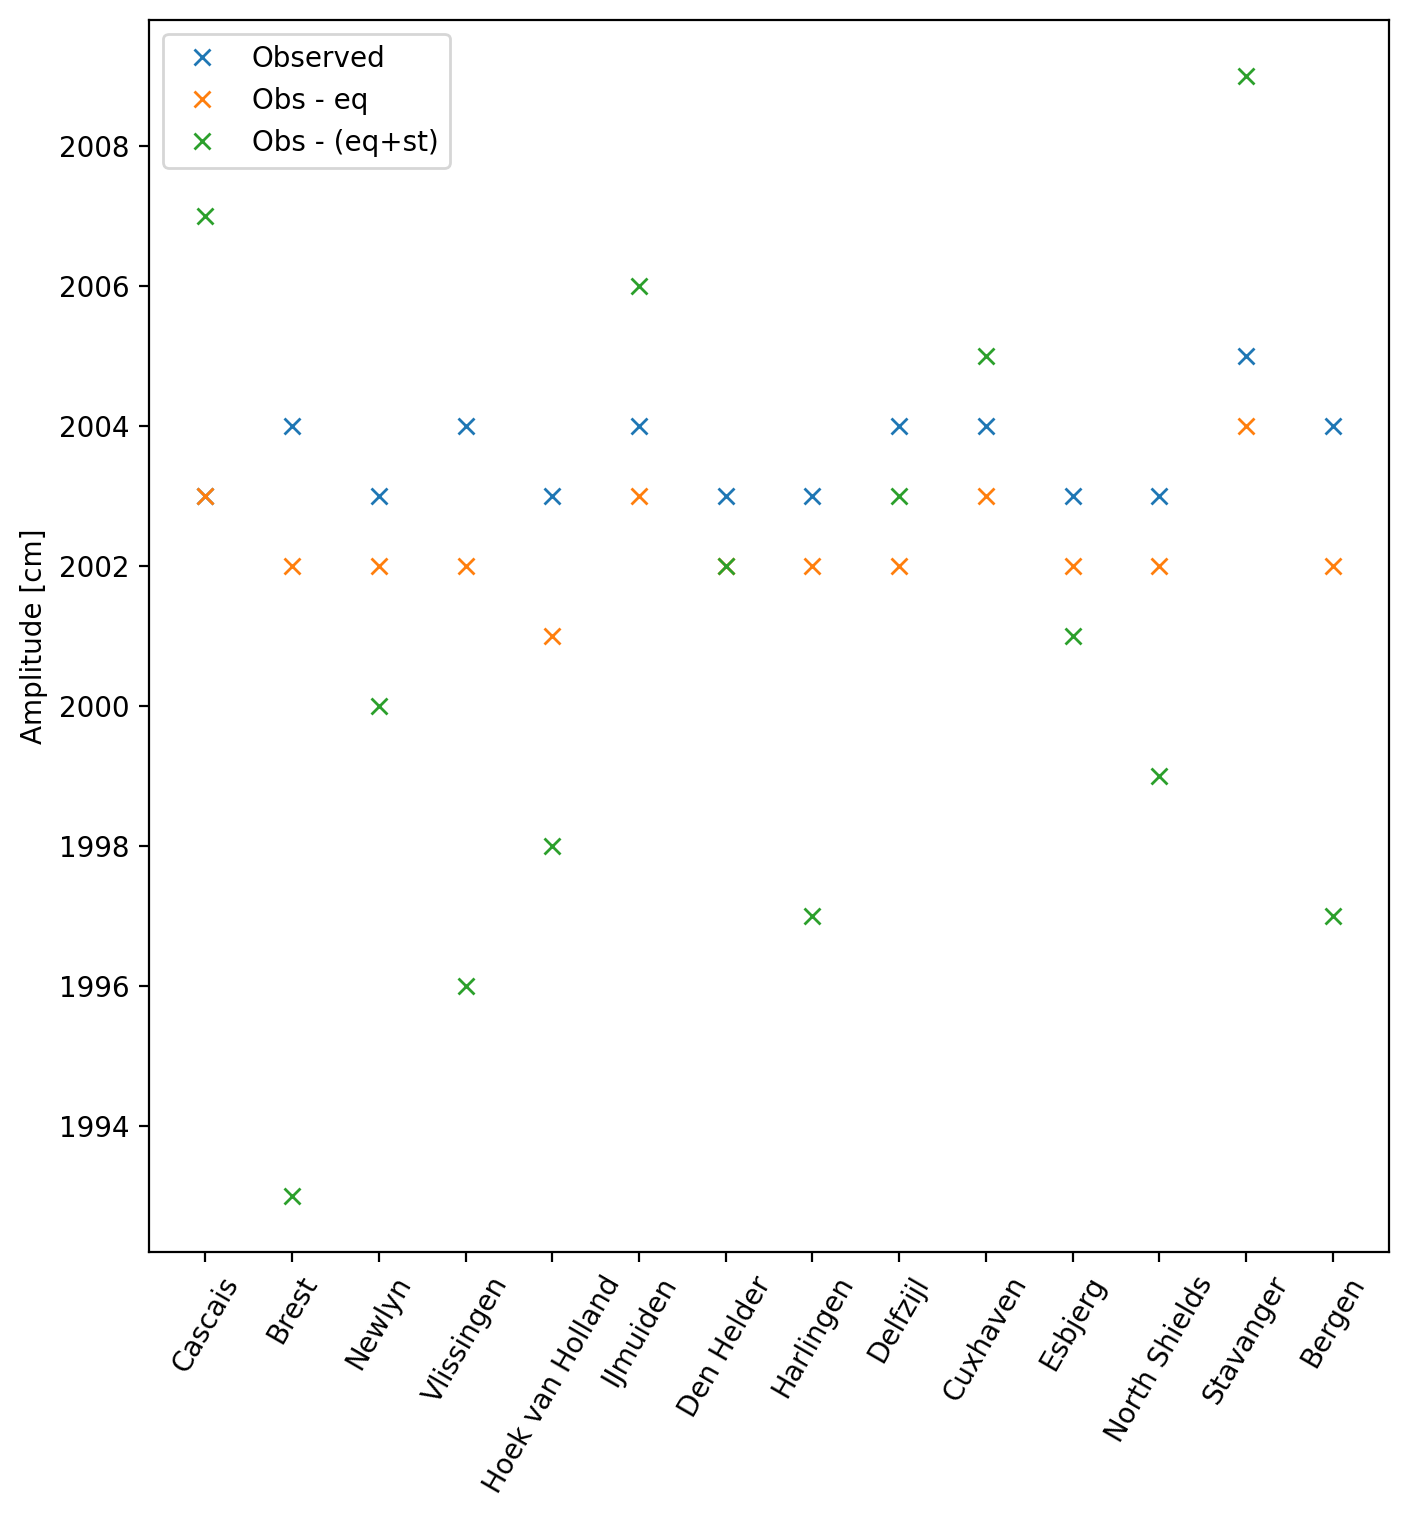

In [25]:
fig = plt.figure(figsize=(8,8))

x = np.linspace(0,14,14)

ov2_v = pd.read_csv(f'/Users/sbult/Desktop/Scripts/data/tide gauges/tidegauges_v13.csv')
plt.plot(x,ov2_v['Phase obs'],'x',label='Observed')
plt.plot(x,ov2_v['dP (obs-eq)'],'x',label='Obs - eq')
plt.plot(x,ov2_v['dP (obs-(eq+st))'],'x',label='Obs - (eq+st)')
plt.ylabel('Amplitude [cm]')
plt.xticks(ticks=x,labels=regions,rotation = 60)
plt.legend();

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/phases_combination.pdf', dpi=150)

In [26]:
fn = '/Users/sbult/Desktop/Scripts/data/altimetry/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1M-m_1680178434259.nc'
ds = xr.open_dataset(fn)
ds2 = ds.groupby('time.year').mean('time')

sla = ds2['sla'][7,:,:]
lat = ds2['latitude'][:]
lon = ds2['longitude'][:]
time = ds2['year']

density_ds = density_ds.to_array()
#print(density_ds[0,:,:,:,:])

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: Depre

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


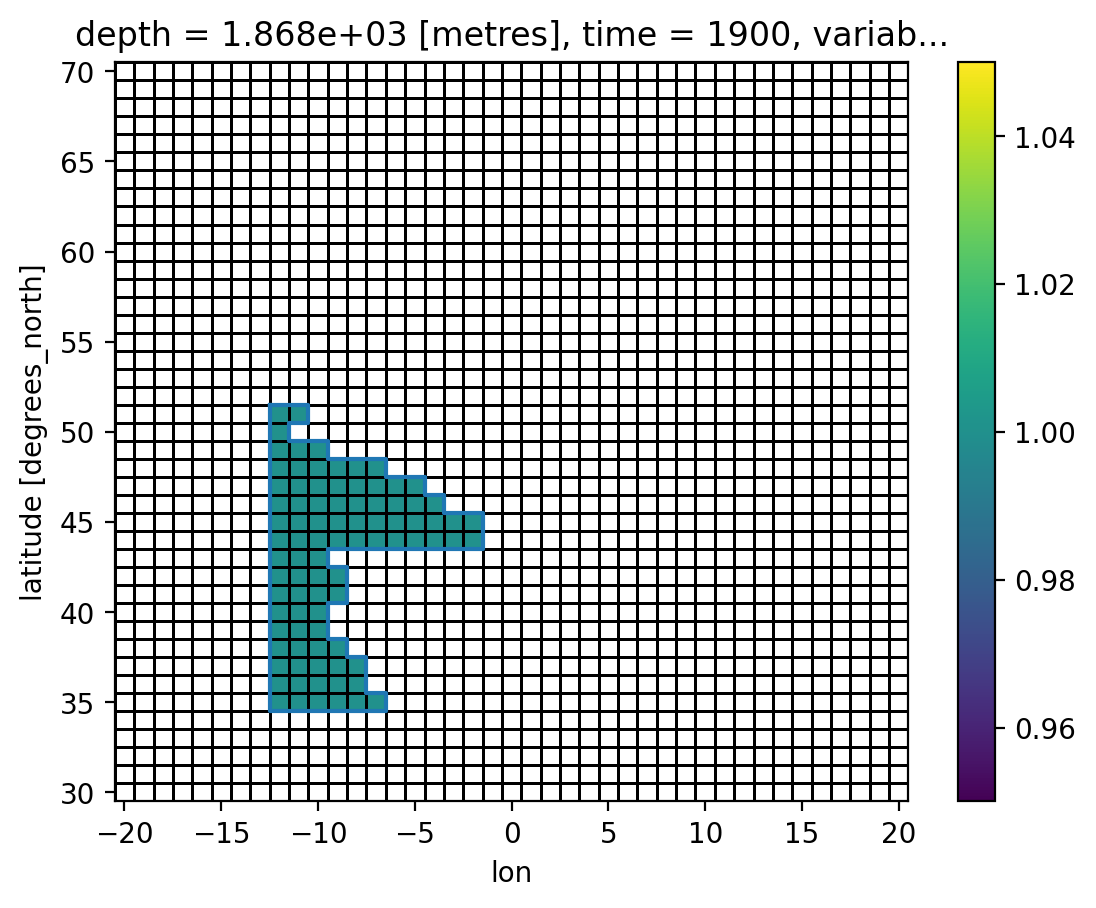

In [27]:
mask = xr.where(np.isnan(density_ds[0,:,:,:,:].sel(depth=2000, method='nearest')), np.NaN, 1)
mask = mask.where(mask.lon <= -2)
mask = mask.where(mask.lon >= -12)
mask = mask.where(mask.lat <= 52)
mask = mask.where(mask.lat >= 35)

mask = mask[0,:,:]
outline_x = np.array([-12.5,-10.5,-10.5,-11.5,-11.5,-9.5,-9.5,-6.5,-6.5,-4.5,-4.5,-3.5,-3.5,-1.5,-1.5,-9.5,-9.5,-8.5,-8.5,-9.5,-9.5,-8.5,-8.5,-7.5,-7.5,-6.5,-6.5,-12.5,-12.5])
outline_y = np.array([51.5,51.5,50.5,50.5,49.5,49.5,48.5,48.5,47.5,47.5,46.5,46.5,45.5,45.5,43.5,43.5,42.5,42.5,40.5,40.5,38.5,38.5,37.5,37.5,35.5,35.5,34.5,34.5,51.5])
mask.plot(edgecolor='k');
plt.plot(outline_x,outline_y);

In [28]:
bed = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/ETOPO_2022_v1_60s_N90W180_bed.nc')

top = bed.z
min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
top = top.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

lon = top.lon
lat = top.lat

print(np.max(top))

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


<xarray.DataArray 'z' ()>
array(4209.76953125)


/var/folders/5p/1w5sgxfn3cgc75rnjycv0_680000gn/T/ipykernel_823/447173779.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(outline_x,outline_y,'k',transform=ccrs.PlateCarree(),color='black',zorder=1)


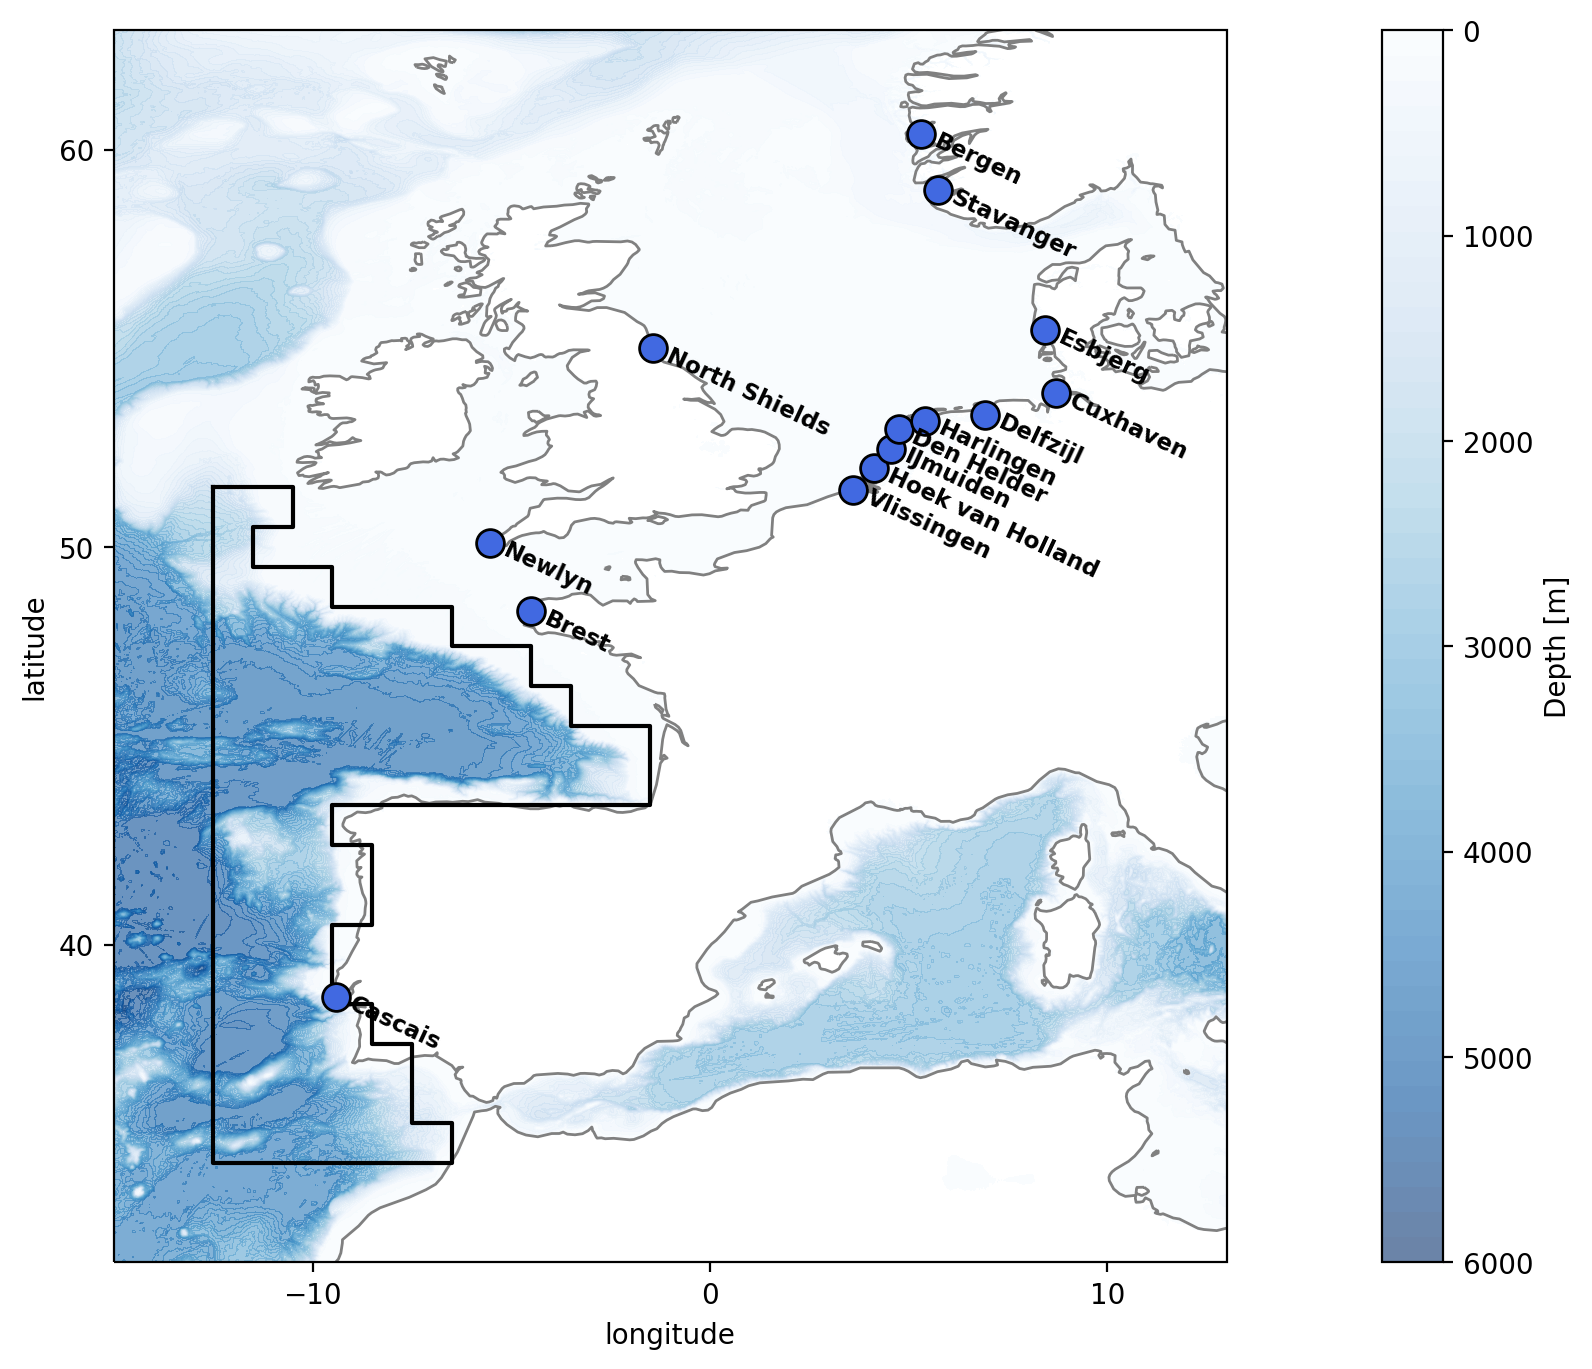

In [30]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())

levels = np.linspace(-6000, 0)

x = plt.contourf(lon, lat, top, 60, transform=ccrs.PlateCarree(),alpha=0.6,cmap='Blues_r',levels=levels,zorder=-1)

ax.coastlines(color='grey',zorder=0)

regions = ['Cascais','Brest','Newlyn','Vlissingen','Hoek van Holland','IJmuiden','Den Helder','Harlingen','Delfzijl','Cuxhaven','Esbjerg','North Shields','Stavanger','Bergen']

lats2 = [38.683333,48.382850,50.103000,51.442222,51.977500,52.462222,52.964444,53.18,53.326389,53.866667,55.460833,55.007444,58.974339,60.398046]
lons2 = [-9.416667,-4.494838,-5.542833,3.596111,4.12000,4.554722,4.745000,5.409,6.933056,8.716667,8.441111,-1.439778,5.730121,5.320487]

outline_x = np.array([-12.5,-10.5,-10.5,-11.5,-11.5,-9.5,-9.5,-6.5,-6.5,-4.5,-4.5,-3.5,-3.5,-1.5,-1.5,-9.5,-9.5,-8.5,-8.5,-9.5,-9.5,-8.5,-8.5,-7.5,-7.5,-6.5,-6.5,-12.5,-12.5])
outline_y = np.array([51.5,51.5,50.5,50.5,49.5,49.5,48.5,48.5,47.5,47.5,46.5,46.5,45.5,45.5,43.5,43.5,42.5,42.5,40.5,40.5,38.5,38.5,37.5,37.5,35.5,35.5,34.5,34.5,51.5])

plt.plot(outline_x,outline_y,'k',transform=ccrs.PlateCarree(),color='black',zorder=1)

s_ampl = 100

for i in range(len(lats2)):
    plt.text(lons2[i]+0.3,lats2[i]-0.3,regions[i],fontsize='small',fontweight='bold',rotation_mode='anchor',rotation=335)

plt.scatter(lons2, lats2,transform=ccrs.PlateCarree(),s=s_ampl,zorder=2,color='royalblue',edgecolor='black')

ax.set_xticks([-20,-10,0,10], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60], crs=ccrs.PlateCarree())
ax.set_ylim([32,63])
ax.set_xlim([-15,13]);
ax.set_ylabel('latitude')
ax.set_xlabel('longitude');

cbar = plt.colorbar(x,label='Depth [m]')
cbar.set_ticks([0,-1000,-2000,-3000,-4000,-5000,-6000])
cbar.set_ticklabels([0,1000,2000,3000,4000,5000,6000]);

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/overview_stations.png', dpi=200)

In [70]:
fn = '/Users/sbult/Desktop/Scripts/data/altimetry/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679401028951.nc'
ds = xr.open_dataset(fn)
ds2 = ds.groupby('time.year').mean('time')

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


In [71]:
ds2

<xarray.Dataset>
Dimensions:    (year: 30, latitude: 43, longitude: 55)
Coordinates:
  * latitude   (latitude) float32 49.12 49.38 49.62 49.88 ... 59.12 59.38 59.62
  * longitude  (longitude) float32 -6.375 -6.125 -5.875 ... 6.625 6.875 7.125
  * year       (year) int64 1993 1994 1995 1996 1997 ... 2019 2020 2021 2022
Data variables:
    adt        (year, latitude, longitude) float64 -0.008367 -0.008433 ... nan
    crs        (year) float64 -2.147e+09 -2.147e+09 ... -2.147e+09 -2.147e+09
    sla        (year, latitude, longitude) float64 -0.004321 -0.00377 ... nan
    err_sla    (year, latitude, longitude) float64 0.02304 0.02676 ... nan nan

         Steric      nod1      nod2
year                               
1993  -0.952164  1.000000  0.000000
1994   1.412384  0.943562  0.331195
1995   0.863205  0.780620  0.625006
1996  -7.084016  0.529565  0.848270
1997   1.511973  0.218735  0.975784
1998   3.872000 -0.116785  0.993157
1999   3.834740 -0.439123  0.898427
2000   2.414727 -0.711894  0.702287
2001   3.132740 -0.904310  0.426876
2002   2.913151 -0.994652  0.103281
2003   4.478192 -0.972722 -0.231972
2004   5.274071 -0.840996 -0.541041
2005   1.884438 -0.614342 -0.789040
2006   3.014137 -0.318344 -0.947975
2007  10.751178  0.013587 -0.999908
2008   4.941366  0.343984 -0.938975
2009  -0.063233  0.635555 -0.772056
2010   1.088603  0.855386 -0.517990
2011   5.636110  0.978666 -0.205457
2012   1.793197  0.991479  0.130268
2013   2.124932  0.892378  0.451289
2014   3.489781  0.692550  0.721370
2015   6.457616  0.414549  0.910027
2016   6.728115  0.089757  0.995964
2017  12.953096 -0.245167  0.969481
2018   2.023452 -0.552417  0

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
/opt/anaconda3/lib/pyt

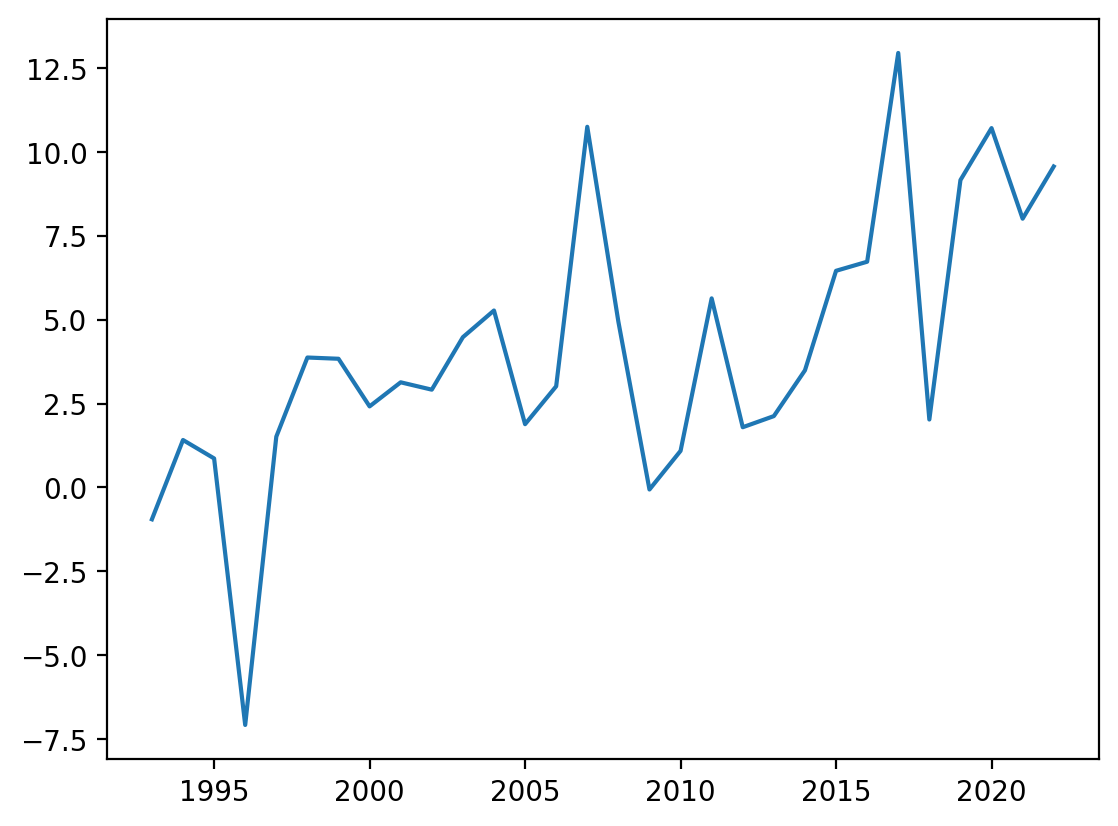

In [72]:
sla = ds2['sla'].sel(latitude=52.462222, longitude=4.554722, method='nearest') * 100
time = ds2['year']

pf = sla.to_dataframe()
pf['nod1'] = np.cos(2*np.pi*(time - time[0])/18.613)
pf['nod2'] = np.sin(2*np.pi*(time - time[0])/18.613)
del pf['latitude']
del pf['longitude']
pf.columns = ["Steric","nod1","nod2"]

plt.plot(time,sla);
print(pf)

In [73]:
res_nr2, res_full_nr2 = compute_model(pf)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:804: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sum(resid / self.family.variance(mu)) / self.df_resid


In [74]:
res_nr2.columns = ['nod1','nod2','trend','total','obs']
res_nr2

nod1      nod2     trend     total       obs
year                                                  
1993 -1.735474 -0.000000  0.238142 -1.497331 -1.735474
1994 -1.637528 -0.046413  0.494549 -1.189392 -1.683941
1995 -1.354745 -0.087587  0.751053 -0.691280 -1.442332
1996 -0.919045 -0.118875  1.007958 -0.029963 -1.037920
1997 -0.379608 -0.136745  1.265573  0.749221 -0.516353
1998  0.202678 -0.139179  1.523812  1.587311  0.063498
1999  0.762086 -0.125904  1.782534  2.418716  0.636182
2000  1.235474 -0.098417  2.041796  3.178852  1.137057
2001  1.569407 -0.059822  2.301767  3.811352  1.509585
2002  1.726193 -0.014474  2.562590  4.274310  1.711719
2003  1.688134  0.032508  2.824315  4.544957  1.720642
2004  1.459527  0.075820  3.086897  4.622245  1.535347
2005  1.066175  0.110575  3.350275  4.527024  1.176750
2006  0.552478  0.132847  3.614376  4.299702  0.685326
2007 -0.023579  0.140125  3.878953  3.995499  0.116546
2008 -0.596976  0.131586  4.143735  3.678346 -0.465389
2009 -1.102988  0.108194  4.408904  3.414110 -0.994794
2010 -1.484501  0.072590  4.674776  3.262866 -1.411910
2011 -1.698449  0.028792  4.941422  3.271765 -1.669657
2012 -1.720685 -0.018256  5.208761  3.469820 -1.738941
2013 -1.548698 -0.063243  5.476782  3.864841 -1.611941
2014 -1.201902 -0.101092  5.745394  4.442401 -1.302993
2015 -0.719440 -0.127529  6.014331  5.167362 -0.846969
2016 -0.155771 -0.139573  6.283277  5.987933 -0.295343
2017  0.425481 -0.135861  6.551958  6.841577  0.289619
2018  0.958706 -0.116815  6.820343  7.662234  0.841891
2019  1.383717 -0.084583  7.088632  8.387766  1.299134
2020  1.652540 -0.042803  7.356850  8.966587  1.609737
2021  1.734833  0.003808  7.624960  9.363601  1.738641
2022  1.621306  0.049989  7.893048  9.564343  1.671294

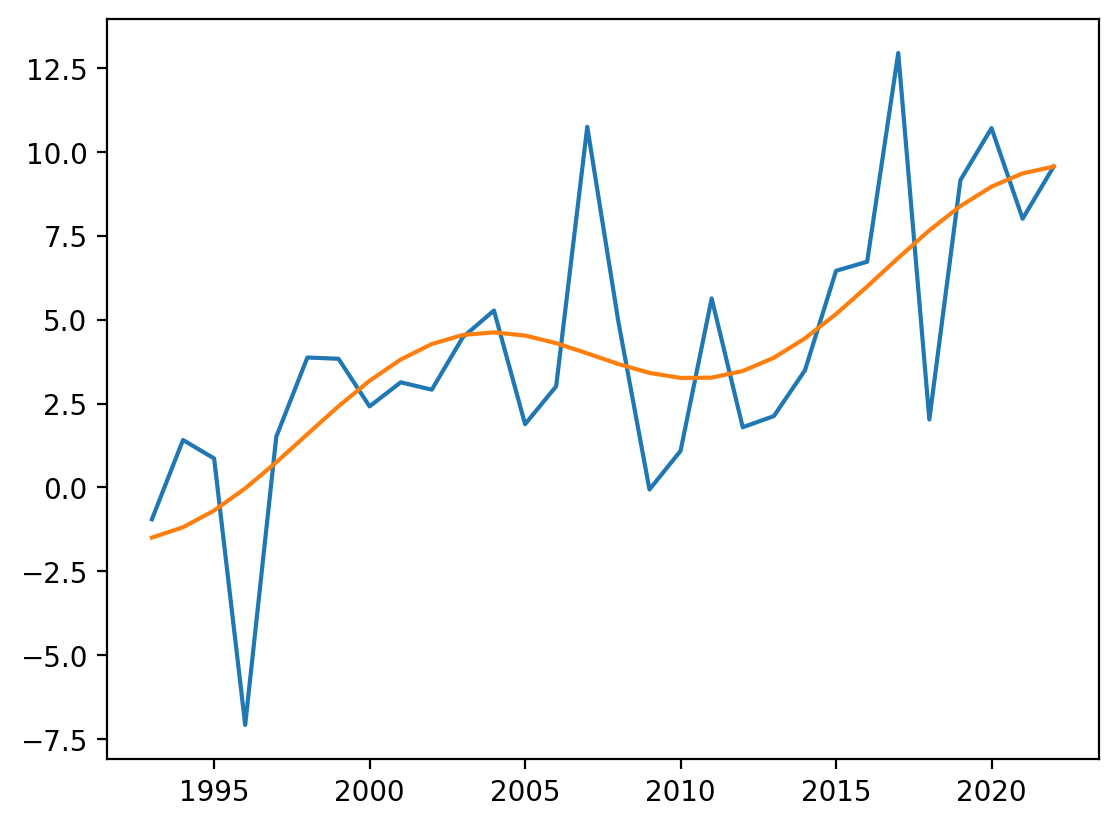

In [75]:
plt.plot(pf["Steric"]);
plt.plot(res_nr2["total"]);

In [52]:
nodal_df = et.join([res_nr2["obs"],res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]

<AxesSubplot:xlabel='time'>

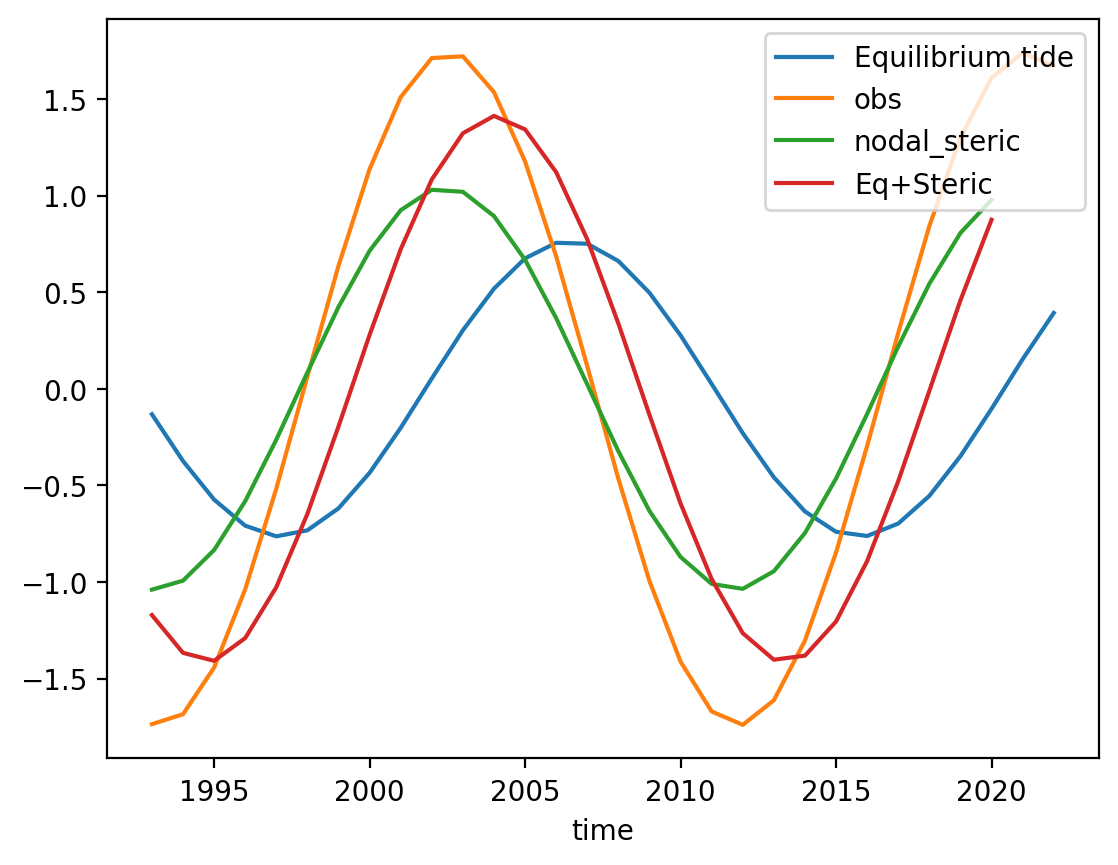

In [53]:
nodal_df.loc[1993:2022].plot()

In [54]:
region = ['IJmuiden','Vlissingen','Den Helder','Brest','Newlyn','Stavanger','Cuxhaven','Hoek van Holland','Harlingen','Cascais','Delfzijl','Esbjerg','Bergen','North Shields']

names = ['id','lat','lon']
ov = np.zeros([len(region),3])

for i in range(len(region)):
    gam = pd.read_csv(f"/Users/sbult/Desktop/Scripts/data/tide gauges/output/{region[i]}/results_NearestPointAverage2.csv")
    gam.set_index("time", inplace=True)
    obs_nod = gam["nod1"]+gam["nod2"]
    obs_nod.name = "Observed cycle"
    
    if region[i] == 'IJmuiden':
        latitude = latitude_netherlands
        tg_id = 32
    elif region[i] == 'Vlissingen':
        latitude = latitude_netherlands
        tg_id = 20
    elif region[i] == 'Den Helder':
        latitude = latitude_netherlands
        tg_id = 23
    elif region[i] == 'Hoek van Holland':
        latitude = latitude_netherlands
        tg_id = 22
    elif region[i] == 'Harlingen':
        latitude = latitude_netherlands
        tg_id = 25
    elif region[i] == 'Delfzijl':
        latitude = latitude_netherlands
        tg_id = 24
    elif region[i] == 'Brest':
        latitude = latitude_brest
        tg_id = 1
    elif region[i] == 'Newlyn':
        latitude = latitude_newlyn
        tg_id = 202
    elif region[i] == 'Stavanger':
        latitude = latitude_stavanger
        tg_id = 47
    elif region[i] == 'Cuxhaven':
        latitude = latitude_denmark
        tg_id = 7
    elif region[i] == 'Cascais':
        latitude = latitude_cascais
        tg_id = 52
    elif region[i] == 'Esbjerg':
        latitude = latitude_esbjerg
        tg_id = 80
    elif region[i] == 'Bergen':
        latitude = latitude_bergen
        tg_id = 58
    elif region[i] == 'North Shields':
        latitude = latitude_northshields
        tg_id = 95
        
    lat, lon = slc.tg_lat_lon(tg_id)
    
    ov[i,0] = tg_id
    ov[i,1] = lat
    ov[i,2] = lon

ov2 = pd.DataFrame(ov,columns=names,index=region)
ov2.sort_values(by=['id'],ascending=True,inplace=True)
ov2

id        lat       lon
Brest               1.0  48.382850 -4.494838
Cuxhaven            7.0  53.866667  8.716667
Vlissingen         20.0  51.442222  3.596111
Hoek van Holland   22.0  51.977500  4.120000
Den Helder         23.0  52.964444  4.745000
Delfzijl           24.0  53.326389  6.933056
Harlingen          25.0  53.175556  5.409444
IJmuiden           32.0  52.462222  4.554722
Stavanger          47.0  58.974339  5.730121
Cascais            52.0  38.683333 -9.416667
Bergen             58.0  60.398046  5.320487
Esbjerg            80.0  55.460833  8.441111
North Shields      95.0  55.007444 -1.439778
Newlyn            202.0  50.103000 -5.542833

In [55]:
def thickness_from_depth(depth):
    '''Define a thickness Data Array from depth coordinate'''
    midp = (np.array(depth[1:])+np.array(depth[:-1]))/2
    midp = np.insert(midp, 0, np.array([0]))
    midp = np.insert(midp, len(midp), np.array(depth[-1]) + 
                     (np.array(depth[-1]) - np.array(depth[-2])))
    thick = midp[1:] - midp[:-1]
    thick_da = xr.DataArray(thick, coords={'depth': depth[:]}, dims='depth')
    return thick_da

def StericSL2(data_source, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'IAP':
        density_ds = xr.open_mfdataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_IAP/density_teos10_iap_*.nc')
    elif data_source == 'EN4_22':
        density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da
    
    rho_0 = density_ds.density[0 ,0 ,: ,:];
    
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL

In [56]:
density_ds = xr.open_dataset('/Users/sbult/Desktop/Scripts/data/StericDataSterre/DataSteric/density_teos10_en422_g10_1900_2022.nc')

ster = StericSL2('EN4_22',0,500,0)
ster = ster.loc[1980:]
ster = ster.sel(lat=48,lon=-4,method='nearest')

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [76]:
reg_df['Steric'] = reg_df['Steric'] + ster[:-1]

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)


In [58]:
res_nr, res_full_nr = compute_model(reg_df)

In [59]:
nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]

KeyError: "Steric_['IJmuiden', 'Vlissingen', 'Den Helder', 'Brest', 'Newlyn', 'Stavanger', 'Cuxhaven', 'Hoek van Holland', 'Harlingen', 'Cascais', 'Delfzijl', 'Esbjerg', 'Bergen', 'North Shields']"

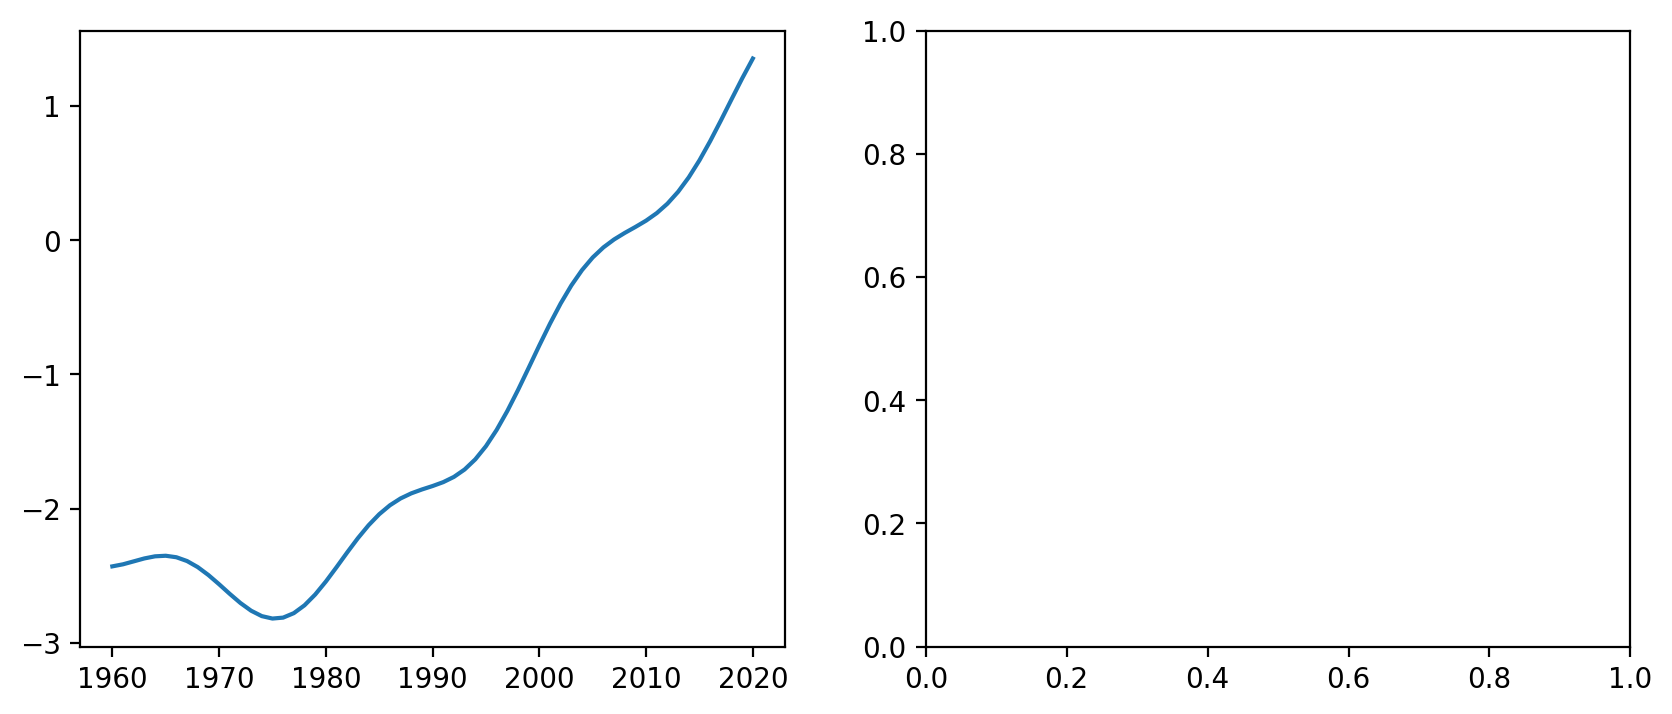

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))


ax[0].plot(res_nr["total"], label="Trend and nodal fit")
ax[0].plot(StericSL_df[f"Steric_{region}"], label=f"Observed steric in {region}" )

ax[0].legend()

nodal_df.plot(ax=ax[1])

#ax[1].set_xlim([1975,1993])
ax[1].set_xlim([1993,2011])

for i in range(2):
    ax[i].set_xlabel("Time [years]")
    ax[i].set_ylabel("Sea level [cm]")

#plt.savefig('/Users/sbult/Desktop/Scripts/data/tide gauges/figures/NodalCycleNorthShields.pdf', dpi=150)

In [50]:
new = nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]

<AxesSubplot:xlabel='time'>

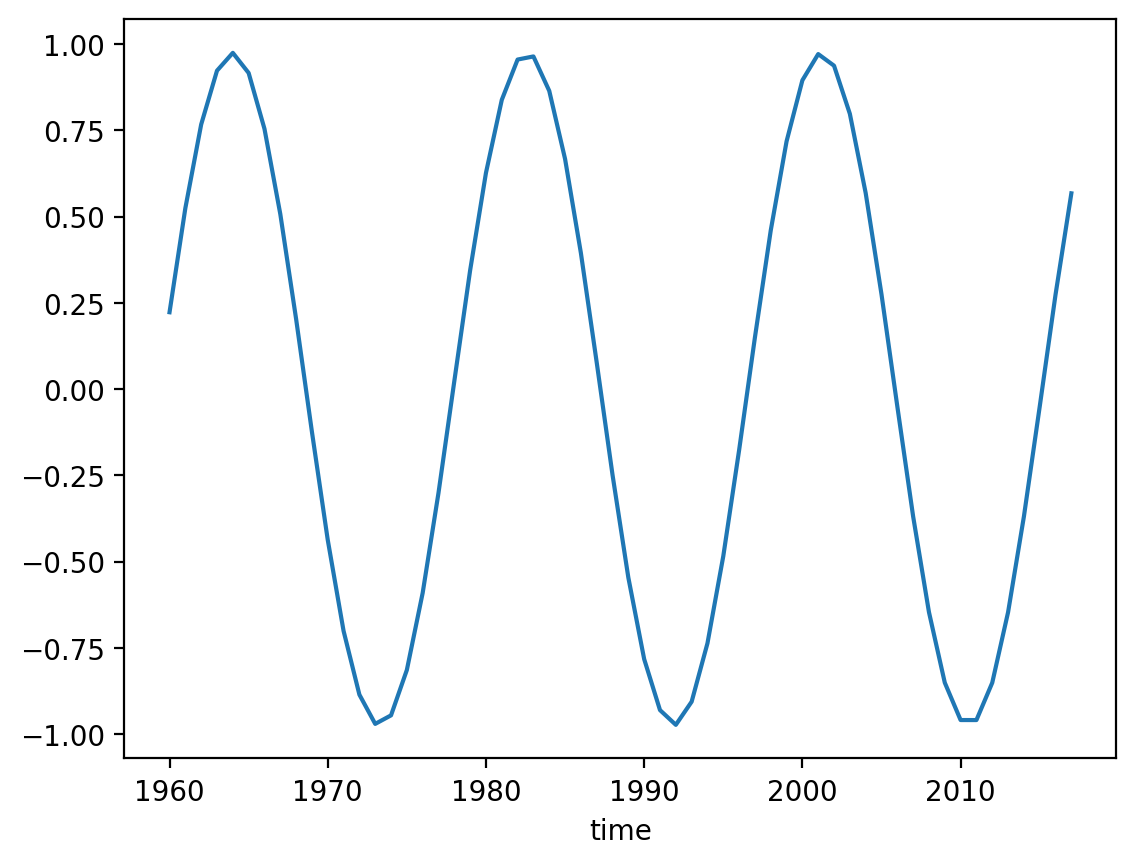

In [51]:
new.plot()

In [52]:
print(np.shape(ov))

(14, 3)


0.34575350214324535


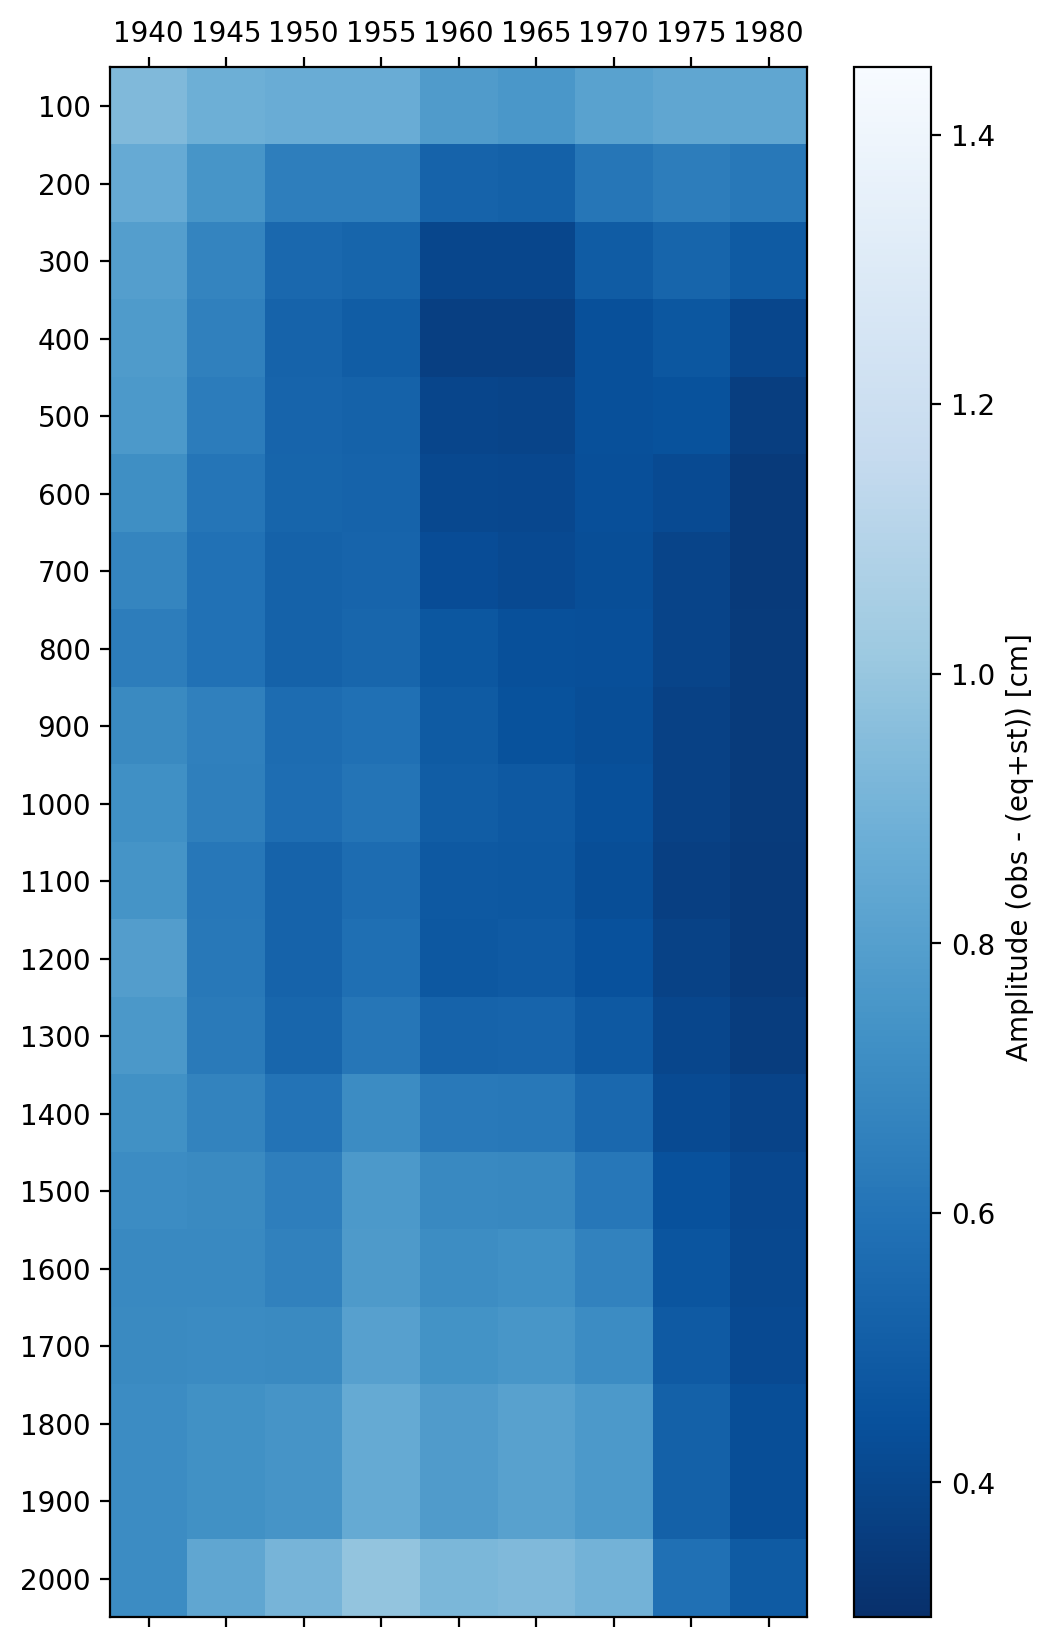

In [104]:
ov2 = ov.mean(axis=0)
ph2 = ph.mean(axis=0)

print(np.min(ov2))

fig = plt.figure(figsize=(6,10));
plt.matshow(ov2,cmap='Blues_r',fignum=1,vmax=1.45,vmin=0.3)
plt.colorbar(label='Amplitude (obs - (eq+st)) [cm] ')
plt.yticks(ticks=np.arange(0,20),labels=max_depth)
plt.xticks(ticks=np.arange(0,9),labels=start_year);
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/Overview_amplitude_IAP.png', dpi=150)

# Selection of year and integration depth

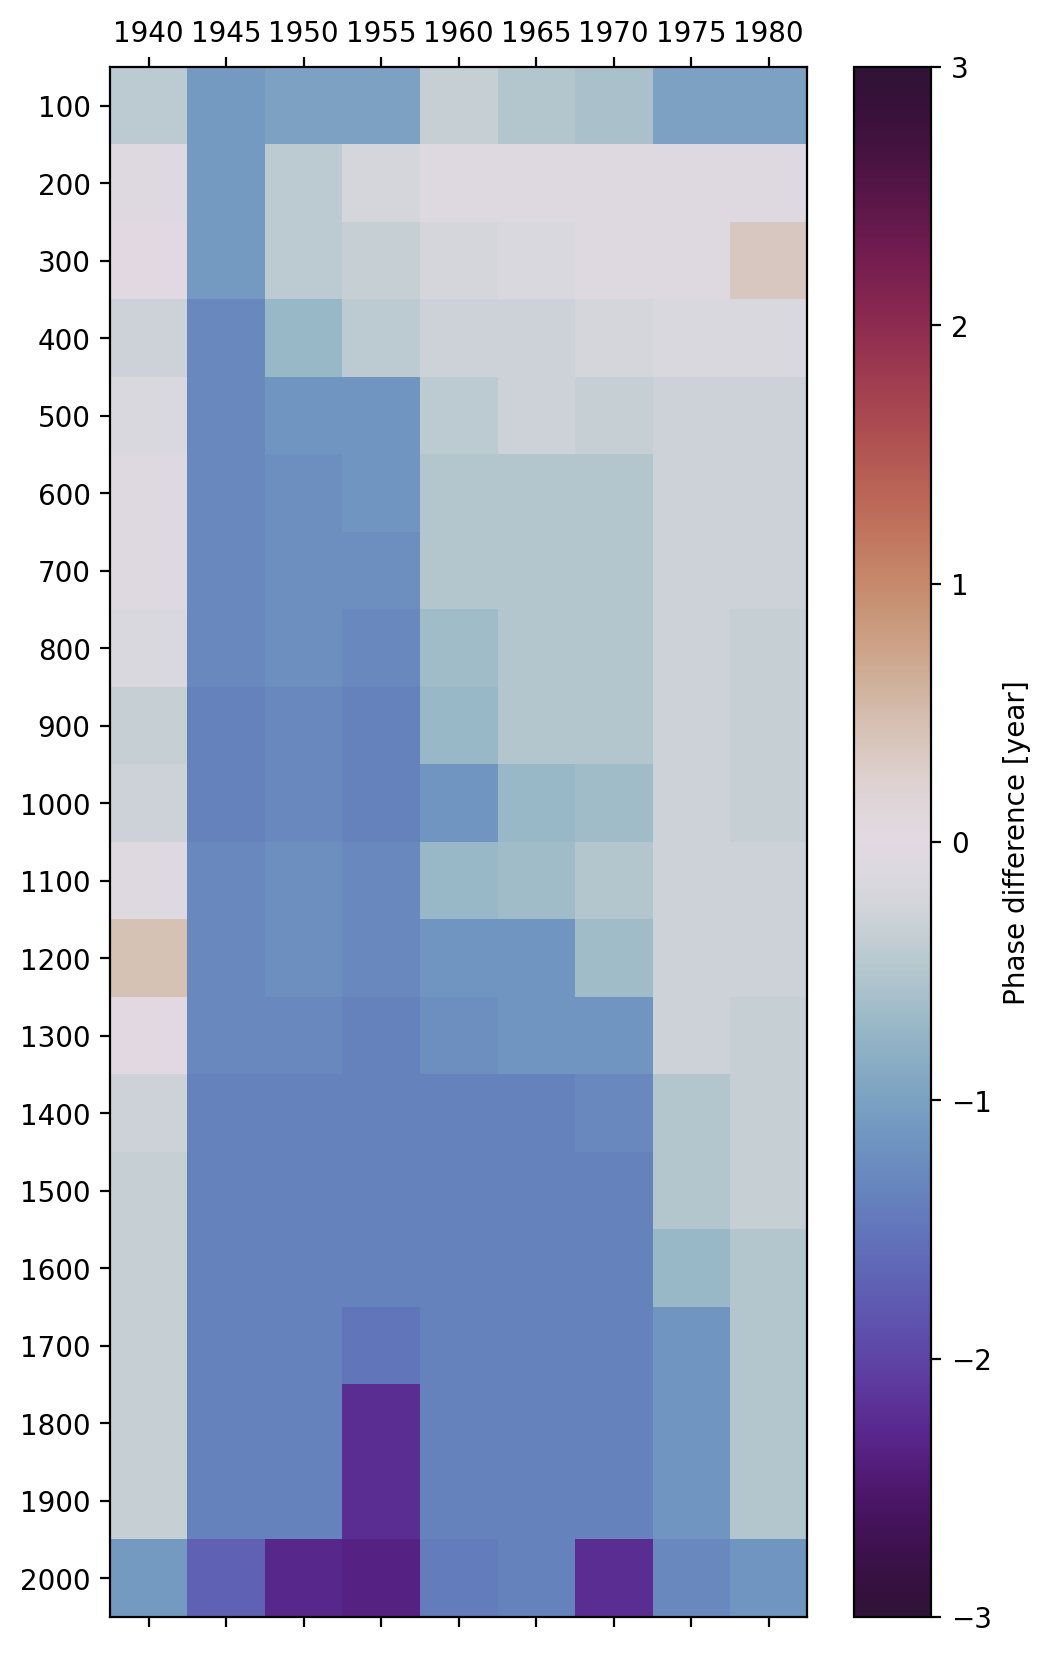

In [91]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(6,10));
plt.matshow(ph2,cmap='twilight_shifted',fignum=1,norm=TwoSlopeNorm(vcenter=0,vmax=3,vmin=-3))
cb = plt.colorbar(label='Phase difference [year]',spacing='uniform')
plt.clim([-3,3])
plt.yticks(ticks=np.arange(0,20),labels=max_depth)
plt.xticks(ticks=np.arange(0,9),labels=start_year);

cb.ax.set_yscale('linear')
#plt.savefig('/Users/sbult/Desktop/Scripts/data/StericDataSterre/Overview_phase_v2_IAP.png', dpi=150)

In [86]:
regions = ['IJmuiden','Vlissingen','Den Helder','Brest','Newlyn','Stavanger','Cuxhaven','Hoek van Holland','Harlingen','Cascais','Delfzijl','Esbjerg','Bergen','North Shields']

max_depth = np.arange(100,2100,100)
region = "EBB"
start_year = np.arange(1940,1985,5)
end_year = 2020

ov = np.zeros((len(regions),len(max_depth),len(start_year)))
ph = np.zeros((len(regions),len(max_depth),len(start_year)))

for j in range(len(max_depth)):
    StericSL_EBB_df = slc.StericSL('IAP', 'EBB', 0, max_depth[j], 0)

    StericSL_EBB_df.columns = ["Steric_EBB"]

    StericSL_df = StericSL_EBB_df
    
    ster = StericSL2('EN4_22',0,max_depth[j],0)
    for k in range(len(start_year)):
        start_year2 = start_year[k]
        StericSL_df = StericSL_df.loc[start_year2:end_year]
        
        t = StericSL_df.index

        reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

        reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
        reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
        ster2 = ster.loc[start_year2:end_year]
        for i in range(len(regions)):
            gam = pd.read_csv(f"/Users/sbult/Desktop/Scripts/data/tide gauges/output/{regions[i]}/results_NearestPointAverage2.csv")
            gam.set_index("time", inplace=True)
            obs_nod = gam["nod1"]+gam["nod2"]
            obs_nod.name = "Observed cycle"

            if regions[i] == 'IJmuiden':
                latitude = latitude_netherlands
                tg_id = 32
            elif regions[i] == 'Vlissingen':
                latitude = latitude_netherlands
                tg_id = 20
            elif regions[i] == 'Den Helder':
                latitude = latitude_netherlands
                tg_id = 23
            elif regions[i] == 'Hoek van Holland':
                latitude = latitude_netherlands
                tg_id = 22
            elif regions[i] == 'Harlingen':
                latitude = latitude_netherlands
                tg_id = 25
            elif regions[i] == 'Delfzijl':
                latitude = latitude_netherlands
                tg_id = 24
            elif regions[i] == 'Brest':
                latitude = latitude_brest
                tg_id = 1
            elif regions[i] == 'Newlyn':
                latitude = latitude_newlyn
                tg_id = 202
            elif regions[i] == 'Stavanger':
                latitude = latitude_stavanger
                tg_id = 47
            elif regions[i] == 'Cuxhaven':
                latitude = latitude_denmark
                tg_id = 7
            elif regions[i] == 'Cascais':
                latitude = latitude_cascais
                tg_id = 52
            elif regions[i] == 'Esbjerg':
                latitude = latitude_esbjerg
                tg_id = 80
            elif regions[i] == 'Bergen':
                latitude = latitude_bergen
                tg_id = 58
            elif regions[i] == 'North Shields':
                latitude = latitude_northshields
                tg_id = 95

            lats, lons = slc.tg_lat_lon(tg_id)

            ster3 = ster2.sel(lat=lats,lon=lons-2,method='nearest')

            et = slc.nodal_tides_potential(latitude, gam.index)
            et = et.rename(columns={"Nodal":"Equilibrium tide"})
            
            reg_df['Steric'] = reg_df['Steric']
                
            res_nr, res_full_nr = compute_model(reg_df)
    
            nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])
            nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
            
            if regions[i] == 'Cascais':
                ov[i,j,k] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].max()
                ph[i,j,k] = nodal_df["Observed cycle"].loc[1975:1993].idxmax() - nodal_df["Eq+Steric"].loc[1975:1993].idxmax()
            else:
                ov[i,j,k] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].max()
                ph[i,j,k] = nodal_df["Observed cycle"].loc[1993:2011].idxmax() - nodal_df["Eq+Steric"].loc[1993:2011].idxmax()

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
